# Problema de Negócio

##### **Qual o contexto do problema?**

<h5>A Rossmann é a uma das maiores redes de farmácia da Europa, com lojas abertas em 7 países. Múltiplos fatores influenciam as vendas das lojas, entre os quais: dia da semana; semana do ano; feriados; mês; promoções e duração de períodos promocionais e distância de lojas concorrentes.</h5>

##### **Qual a causa raiz do problema?**

<h5>O novo CFO da Rossmann solicitou aos gerentes das lojas uma previsão de vendas para as próximas 6 semanas pois precisa estimar a receita da empresa para, posteriormente, programar as despesas com reforma das lojas. Dessa forma, a equipe de cientistas de dados da Rossmann precisa construir um modelo preditivo das vendas nas próximas 6 semanas.</h5>

##### **Quem é o principal interessado no problema?**

<h5>O CFO da Rossmann está interessado em reformar as lojas para aumentar as vendas diárias.</h5>

##### **Qual o formato da solução?**

<h5>No primeiro ciclo de trabalho da equipe de ciência de dados da Rossmann, foi definido o formato inicial de entrega dos resultados: previsão das vendas semanais para cada loja nas próximas 6 semanas. Um modelo de aprendizado de máquina será ajustado para prever as vendas diárias das lojas e, posteriormente, as previsões serão agrupadas por semana. Uma interface de aplicação de programação (em inglês, <i>Application Programming Interface - API</i>) será construída para disponibilizar ao CFO  a previsão total das vendas nas próximas 6 semanas através do aplicativo Telegram.</h5>

# Bibliotecas

In [1]:
from tabulate import tabulate
#-------------------------------------------
import pandas as pd
import inflection
import math
import numpy as np
import datetime
from scipy import stats as ss
import pickle
import random
import seaborn as sns
#-------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
#-------------------------------------------
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
#-------------------------------------------
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
#-------------------------------------------
from boruta import BorutaPy
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV  
import xgboost as xgb
#-------------------------------------------
import warnings
warnings.filterwarnings('ignore')

# Passo 00: Hipóteses de Negócio

<h5>Onze hipóteses iniciais quanto ao efeito das principais variáveis sobre as vendas diárias foram construídas a partir de conversas com os gerentes das lojas.</h5>

In [8]:
tab = [['Hipótese', 'Descrição'],
       ['H1',       'Lojas com maior sortimento vendem mais.'],
       ['H2',       'Lojas com maior quantidade de competidores próximos vendem menos.'],
       ['H3',       'Lojas com concorrentes a mais tempo vendem mais.'],
       ['H4',       'Lojas com promoções ativas por mais tempo vendem mais.'],
       ['H5',       'Lojas com mais dias de promoções consecutivas vendem mais.'],
       ['H6',       'Lojas abertas durante o Natal vendem mais.'],
       ['H7',       'As vendas das lojas cresceram ao longo do tempo.'],
       ['H8',       'Lojas vendem mais no segundo semestre do ano.'],
       ['H9',       'Lojas vendem mais após o dia 10 de cada mês.'],
       ['H10',      'Lojas vendem menos nos finais de semana.'],
       ['H11',      'Lojas vendem menos durante feriados escolares.'],
      ]
print(tabulate(tab, headers='firstrow'))

Hipótese    Descrição
----------  -----------------------------------------------------------------
H1          Lojas com maior sortimento vendem mais.
H2          Lojas com maior quantidade de competidores próximos vendem menos.
H3          Lojas com concorrentes a mais tempo vendem mais.
H4          Lojas com promoções ativas por mais tempo vendem mais.
H5          Lojas com mais dias de promoções consecutivas vendem mais.
H6          Lojas abertas durante o Natal vendem mais.
H7          As vendas das lojas cresceram ao longo do tempo.
H8          Lojas vendem mais no segundo semestre do ano.
H9          Lojas vendem mais após o dia 10 de cada mês.
H10         Lojas vendem menos nos finais de semana.
H11         Lojas vendem menos durante feriados escolares.


# Passo 01: Coleta, Descrição e Limpeza dos dados

<h5><strong>Fonte:</strong><a href="https://www.kaggle.com/competitions/rossmann-store-sales"> Rossmann Sales Prediction</a></h5>

<h5><strong>Data:</strong><a href="https://www.kaggle.com/competitions/rossmann-store-sales/data"> Train, Test and Store .csv files</a></h5>

## Functions

In [2]:
def load_datasets(path1, path2):
    
    df_sales_raw = pd.read_csv(path1, low_memory = False)
    df_store_raw = pd.read_csv(path2, low_memory = False)
    df_raw = pd.merge(df_sales_raw, df_store_raw, on = 'Store', how = 'left')
   
    return df_raw
#-------------------------------------------------------------------------------------
def columns_inflection(df_raw):

    columns = list(df_raw.columns)
    snakecase = lambda x: inflection.underscore(x)
    columns = list(map(snakecase, columns))
    df1 = df_raw.copy()
    df1.columns = columns
   
    return df1
#-------------------------------------------------------------------------------------
def replace_nan(df1):

    df1['date'] = pd.to_datetime(df1['date'], dayfirst = False)
    
    #Os dados faltantes foram substituídos pensando em questões de negócio.
    #Por que não foi gerado dado para determinado atributo?
    
    #Suposição: NaN na coluna 'competition_distance' -> Não há loja concorrente próxima, ou seja, com distância maior que o valor máximo observado nesta coluna
    df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 100000 if math.isnan(x) else x)
    #----------------------------------------------------------------------------------------------------------------
    #Suposição: NaN nas colunas 'competition_open_since_month' e 'competition_open_since_year' -> A loja concorrente ainda não tinha sido aberta
    df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
    df1['competition_open_since_year']  = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
    #----------------------------------------------------------------------------------------------------------------
    #Dados faltantes nas colunas 'promo2_since_week' e 'promo2_since_year'
    #Dados faltanttes pq a loja não estava participando da Promo2
    df1['promo2_since_week']  = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)
    df1['promo2_since_year']  = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)
    #Indicando se o mês da venda estava em período promocional
    month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }
    df1.loc[df1['promo_interval'].isnull() == True, 'promo_interval'] = 0
    df1['month_map'] = df1['date'].dt.month.map(month_map)
    df1['is_promo']  = df1[['month_map', 'promo_interval']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

    return df1
#-------------------------------------------------------------------------------------
def change_dtypes(df1):
    
    df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
    df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
    df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
    df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
    
    return df1

## Steps

In [3]:
path1 = 'datasets/train.csv'
path2 = 'datasets/store.csv'
df_raw = load_datasets(path1, path2)
df1 = columns_inflection(df_raw)
df2 = replace_nan(df1)
df3 = change_dtypes(df2)
print(df3.shape)
print(df3.columns)

(1017209, 20)
Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo'],
      dtype='object')


# Passo 02: *Features engineering*

## Function

In [4]:
def features_engineering(df1):

    #Classificação das distâncias dos competidores
    df1['distance_classification'] = df1['competition_distance'].apply(lambda x: 'Próximo' if x <= 1000 
                                                                       else      'Intermediário' if x <= 10000 
                                                                       else      'Longe')
    #---------------------------------------------------------------------------------------------------------------------
    #Classificação das vendas
    df1['sales_classification'] = df1['sales'].apply(lambda x: 'Normal' if ((x >= 4859)&(x <= 8360) ) 
                                                     else      'Baixa'  if   x < 4859 
                                                     else      'Alta')
    #---------------------------------------------------------------------------------------------------------------------
    #year
    df1['year'] = (df1['date'].dt.year).astype(int)
    #month
    df1['month'] = (df1['date'].dt.month).astype(int)
    #day
    df1['day'] = (df1['date'].dt.day).astype(int)
    #week of year
    #df1['week_of_year'] = (df1['date'].dt.isocalendar().week().astype(int)
    #A função isocalendar().week() atribui valor 1 à semana do dia 31-12-2013 e 2014. Isso pode agrupar as semanas no começo de um ano e começo do ano seguinte
        
    #year_week
    df1['year_week'] = df1['date'].dt.strftime('%Y-%W')
    df1['week_of_year'] = df1['year_week'].str.split('-').str[1].astype(int)

    #competition and promo since
    df1['competition_since'] = df1.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], 
                                                                   month = x['competition_open_since_month'],
                                                                   day =1), axis = 1)

    df1['competition_time_months'] = ((df1['date'] - df1['competition_since'])/30).apply(lambda x: x.days).astype(int)
    #--------------------------------------------------------------------------------------------------------------------
    df1['season'] = df1.apply(lambda x: 'Winter' if (((x['month'] == 12)&(x['day'] > 21))|(x['month'] == 1)|(x['month'] == 2)|((x['month'] == 3)&(x['day'] <= 19))) 
                              else      'Spring' if (((x['month'] == 3)&(x['day'] > 19))|(x['month'] == 4)|(x['month'] == 5)|((x['month'] == 6)&(x['day'] <= 20))) 
                              else      'Summer' if (((x['month'] == 6)&(x['day'] > 20))|(x['month'] == 7)|(x['month'] == 8)|((x['month'] == 9)&(x['day'] <= 22)))
                              else      'Fall', axis=1)
    #--------------------------------------------------------------------------------------------------------------------
    df1['promo_since'] = df1['promo2_since_year'].astype(str) + '-' +  df1['promo2_since_week'].astype(str)
    df1['promo_since'] = df1['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
    df1['promo_time_week']  = ((df1['date'] - df1['promo_since'])/7).apply(lambda x: x.days).astype(int)
    #--------------------------------------------------------------------------------------------------------------------
    df1['assortment'] = df1['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
    #--------------------------------------------------------------------------------------------------------------------
    df1['state_holiday'] = df1['state_holiday'].apply(lambda x: 'Public_holiday' if x == 'a' else 'Easter_holiday' if x == 'b' else 'Christmas' if x == 'c' else 'Regular_day')
    
    return df1

## Step

In [5]:
df4 = features_engineering(df3)
print(df4.columns)

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo',
       'distance_classification', 'sales_classification', 'year', 'month',
       'day', 'year_week', 'week_of_year', 'competition_since',
       'competition_time_months', 'season', 'promo_since', 'promo_time_week'],
      dtype='object')


# Passo 03: Filtragem de variáveis

## Function

In [6]:
def dataframe_filtering(df1):

    df1 = df1[(df1['open'] != 0)&(df1['sales'] > 0)].copy()
    cols_drop = ['open', 'promo_interval', 'month_map'] #Remover a coluna 'open' pq todos os valores são 1
                                                        #Podem ser removidas as colunas 'promo_interval' e 'month_map' pq foram usadas para derivar a coluna 'is_promo'
    df1 = df1.drop(cols_drop, axis=1)

    return df1

## Step

In [7]:
df5 = dataframe_filtering(df4)
print(df5.shape)

(844338, 29)


# Passo 04: Análise Exploratória de Dados (*Exploratory Data Analysis - EDA*)

##### Objetivo: entendimento do negócio da empresa e obtenção de insights 

## Functions

In [103]:
def sales(dataframe):

    sales = dataframe[['sales', 'sales_classification']].copy()
    sales['sales_classification'] = pd.Categorical(sales['sales_classification'], categories = ['Baixa', 'Normal', 'Alta'], ordered = True)
    sales = sales.sort_values('sales_classification')

    fig, ax = plt.subplots(1, 2, figsize = (10,4))
    fig.tight_layout(pad = 3)

    sns.histplot(data = sales, x = 'sales', hue = 'sales_classification', palette = {'Baixa': 'green', 'Normal': 'blue', 'Alta': 'red'}, bins = 50, ax = ax[0])
    ax[0].set_ylabel('Quantidade de registros')
    ax[0].set_xlabel('Vendas por dia')
    ax[0].legend(frameon = False, title = 'Classificação', labels = ['Baixa', 'Normal', 'Alta'])
    

    ax2 = ax[0].twinx()

    sns.kdeplot(dataframe['sales'], fill = False, color='blue', ax = ax2)
    ax2.set_ylabel('')
    ax2.set_yticks([], minor = False)

    sns.boxplot(dataframe['sales'], ax = ax[1])
    ax[1].set_ylabel('Vendas diárias');

    fig.savefig('img/sales_distribution.jpg', bbox_inches = 'tight')
#------------------------------------------------------------------------------------------------------------------------------------------------------------
def sales_customers(dataframe):

    sales = dataframe[['customers', 'sales', 'sales_classification']].copy()
    sales['sales_classification'] = pd.Categorical(sales['sales_classification'], categories = ['Baixa', 'Normal', 'Alta'], ordered = True)
    sales = sales.sort_values('sales_classification')
    
    fig, ax = plt.subplots(figsize = (6,4))

    sns.scatterplot(data = sales, x = 'customers', y = 'sales', hue = 'sales_classification', palette = {'Baixa': 'green', 'Normal': 'blue', 'Alta': 'red'})
    ax.set_ylabel('Vendas diárias')
    ax.set_xlabel('Quantidade de clientes')
    ax.legend(frameon = False, title = 'Classificação das Vendas')

    fig.savefig('img/sales_customers.jpg', bbox_inches = 'tight')
#------------------------------------------------------------------------------------------------------------------------------------------------------------
def h1(df):

    aux1 = df[['store', 'year_week', 'sales', 'assortment']].copy()
    aux1['assortment'] = pd.Categorical(aux1['assortment'], categories = ['basic', 'extended', 'extra'])
    aux1 = aux1.sort_values('assortment')
    #-------------------------------------------------------------------------------------
    groups_assortment = aux1[['store', 'assortment']].groupby('assortment', observed = True)['store'].nunique().reset_index()
    groups_sales_assortment = aux1[['assortment', 'sales']].groupby('assortment', observed = True).median().reset_index()
    merge1 = groups_assortment.merge(groups_sales_assortment, how = 'right', on = 'assortment')

    fig1, ax = plt.subplots(figsize = (5,4))

    sns.barplot(x = merge1['assortment'], y = merge1['store'], color = 'skyblue', ax = ax)
    ax.set_ylabel('Quantidade de lojas')
    ax.set_xlabel('Sortimento')

    ax2 = ax.twinx()

    ax2.plot(merge1['assortment'], merge1['sales'], 'o', color = 'red', linestyle = '')
    ax2.set_ylabel('Mediana de vendas diárias', rotation = -90, labelpad = 10);
#-------------------------------------------------------------------------------------------------------------------------------
def h2(df):

    aux2 = df[['store', 'distance_classification', 'competition_distance', 'sales']].copy()
    #----------------------------------------------------------------------------------------------------------------------------------
    groups_distance = aux2[['competition_distance', 'distance_classification', 'sales']].sort_values('competition_distance', ascending=True).groupby(['competition_distance', 'distance_classification']).median().reset_index()
    #----------------------------------------------------------------------------------------------------------------------------------
    groups_classification = aux2[['distance_classification', 'store']].groupby('distance_classification')['store'].nunique().reset_index()
    groups_classification['distance_classification'] = pd.Categorical(groups_classification['distance_classification'], categories = ['Próximo', 'Intermediário', 'Longe'])
    groups_classification = groups_classification.sort_values('distance_classification')
    #-----------------------------------------------------------------------------------------------------------------------------------
    median_store_distance = aux2[['sales', 'distance_classification']].groupby('distance_classification').median().reset_index()
    median_store_distance['distance_classification'] = pd.Categorical(median_store_distance['distance_classification'], categories = ['Próximo', 'Intermediário', 'Longe'])
    median_store_distance['distance_classification'] = pd.Categorical(median_store_distance['distance_classification'], categories = ['Próximo', 'Intermediário', 'Longe'])
    #-----------------------------------------------------------------------------------------------------------------------------------
    merge2 = groups_classification.merge(median_store_distance, on = 'distance_classification', how = 'inner')
    #-----------------------------------------------------------------------------------------------------------------------------------
    fig3, ax = plt.subplots(figsize = (6,4))

    sns.barplot(x = merge2['distance_classification'], y = merge2['store'], color = 'skyblue', ax = ax)
    ax.set_ylabel('Quantidade lojas')
    ax.set_xlabel('Distância dos concorrentes')

    ax2 = ax.twinx()

    ax2.plot(merge2['distance_classification'], merge2['sales'], 'o', color = 'red', linestyle = '')
    ax2.set_ylabel('Mediana de vendas diárias', rotation = -90, labelpad = 10);
#-------------------------------------------------------------------------------------------------------------------------------
def h3(df):

    aux3 = df.loc[df['competition_since'] != df['competition_since'].min(), ['competition_time_months', 'sales']].copy()
    bins_months = list(np.arange(-50,700,2))
    aux3['bins'] = pd.cut(aux3['competition_time_months'], bins = bins_months)
    aux3 = aux3.sort_values('competition_time_months', ascending = True)
    df_months_negativos = aux3[aux3['competition_time_months']<0] #Valores negativos nos bins: a venda foi efetuada antes da abertura do competidor, ou seja, quando não havia a concorrência
    df_months_positivos = aux3[(aux3['competition_time_months']>0)]
    #---------------------------------------------------------------------------------------------------------------
    groups_bins_negativos     = df_months_negativos[['sales', 'bins']].groupby('bins', observed=True).sum().reset_index()
    groups_bins_negativos_median = df_months_negativos[['sales', 'bins']].groupby('bins', observed=True).median().reset_index()
    df_merge_negativos = groups_bins_negativos.merge(groups_bins_negativos_median, on = 'bins', how = 'inner')
    #---------------------------------------------------------------------------------------------------------------
    groups_bins_positivos        = df_months_positivos[['sales', 'bins']].groupby('bins', observed=True).sum().reset_index()
    groups_bins_positivos_median = df_months_positivos[['sales', 'bins']].groupby('bins', observed=True).median().reset_index()
    df_merge_positivos           = groups_bins_positivos.merge(groups_bins_positivos_median, on = 'bins', how = 'inner')
    #---------------------------------------------------------------------------------------------------------------
    fig5, ax = plt.subplots(figsize = (12,6))

    sns.barplot(x = df_merge_negativos['bins'], y = df_merge_negativos['sales_x'], ax = ax, color = 'red', label = 'Sem concorrência')
    sns.barplot(x = df_merge_positivos['bins'], y = df_merge_positivos['sales_x'], ax = ax, color = 'blue', label = 'Com concorrência')
    ax.legend(frameon=False)
    ax.set_ylim(0,150000000)
    ax.set_xlabel('Tempo de concorrência (meses)')
    ax.set_ylabel('Soma das vendas semanais')

    ax.tick_params(axis='x', labelrotation=90, labelsize=4)
#-------------------------------------------------------------------------------------------------------------------------------
def h4(df):

    aux4 = df[['promo_time_week', 'sales']].copy()
    bins_promo = list(np.arange(-150,321,3))
    aux4['bins'] = pd.cut(aux4['promo_time_week'], bins = bins_promo)
    aux4 = aux4.sort_values('promo_time_week', ascending = True)
    df_promo_negativos = aux4[aux4['promo_time_week']<0] #Valores negativos nos bins: a venda foi efetuada antes do extensão da promoção
    df_promo_positivos = aux4[aux4['promo_time_week']>=0]
    #---------------------------------------------------------------------------------------------------------------
    groups_bins_negativos     = df_promo_negativos[['promo_time_week', 'sales', 'bins']].groupby(['bins', 'promo_time_week'], observed=True).sum().reset_index()
    groups_bins_negativos_median = df_promo_negativos[['sales', 'bins']].groupby('bins', observed=True).median().reset_index()
    df_merge_negativos = groups_bins_negativos.merge(groups_bins_negativos_median, on = 'bins', how = 'inner')
    #---------------------------------------------------------------------------------------------------------------
    groups_bins_positivos        = df_promo_positivos[['promo_time_week', 'sales', 'bins']].groupby(['promo_time_week', 'bins'], observed=True).sum().reset_index()
    groups_bins_positivos2 = groups_bins_positivos.loc[1:, :]
    groups_bins_positivos50 = groups_bins_positivos2[groups_bins_positivos2['promo_time_week']<=50]
    groups_bins_positivos_median = df_promo_positivos[['sales', 'bins']].groupby('bins', observed=True).median().reset_index()
    df_merge_positivos           = groups_bins_positivos.merge(groups_bins_positivos_median, on = 'bins', how = 'inner')
    #---------------------------------------------------------------------------------------------------------------
    fig7, ax = plt.subplots(figsize = (12,6))

    sns.barplot(x = df_merge_negativos['bins'], y = df_merge_negativos['sales_x'], ax = ax, color = 'red', label = 'Sem promoção', errorbar = None)
    sns.barplot(x = df_merge_positivos['bins'], y = df_merge_positivos['sales_x'], ax = ax, color = 'blue', label = 'Com promoção', errorbar = None)
    ax.legend(frameon=False)
    ax.set_ylim(0,15000000)
    ax.set_xlabel('Tempo de promoção (meses)')
    ax.set_ylabel('Soma das vendas semanais')

    ax.tick_params(axis='x', labelrotation=90, labelsize=4);

    return groups_bins_negativos, groups_bins_positivos2, groups_bins_positivos50

def temporal_serie_sales(groups_bins_negativos, groups_bins_positivos2, groups_bins_positivos50):

    fig8, axs = plt.subplots(1,3, figsize = (12,6))

    sns.regplot(x = 'promo_time_week', y = 'sales', data = groups_bins_negativos, ax = axs[0])
    sns.regplot(x = 'promo_time_week', y = 'sales', data = groups_bins_positivos2, ax = axs[1])
    sns.regplot(x = 'promo_time_week', y = 'sales', data = groups_bins_positivos50, ax = axs[2])
    #----------------------------------------------------------------------------------------------------
    r1 = groups_bins_negativos[['promo_time_week', 'sales']].corr().round(2).iloc[1,0]
    r2 = groups_bins_positivos2[['promo_time_week', 'sales']].corr().round(2).iloc[1,0]
    r3 = groups_bins_positivos50[['promo_time_week', 'sales']].corr().round(2).iloc[1,0]
    #----------------------------------------------------------------------------------------------------
    axs[0].annotate('Correlação de Pearson (r): {}'.format(r1), xy = (-125,6500000))
    axs[1].annotate('Correlação de Pearson (r): {}'.format(r2), xy = (30,25000000))
    axs[2].annotate('Correlação de Pearson (r): {}'.format(r3), xy = (5,10500000))
    #----------------------------------------------------------------------------------------------------
    #fig8.savefig('figures/figure8_github.jpg', bbox_inches = 'tight');
#-------------------------------------------------------------------------------------------------------------------------------
def h5(df):

    aux5 = df[['date', 'store', 'promo', 'promo2', 'sales']].copy()
    groups_promo = aux5[['sales', 'promo', 'promo2']].groupby(['promo', 'promo2']).median().reset_index()
    groups_promo_day = aux5[['date', 'promo', 'promo2']].groupby(['promo', 'promo2'])['date'].nunique().reset_index()
    merge3 = groups_promo.merge(groups_promo_day, on = ['promo', 'promo2'], how = 'inner')
    aux6 = aux5[['store', 'promo', 'promo2']].groupby(['promo', 'promo2'])['store'].nunique().reset_index()
    merge3 = merge3.merge(aux6, on = ['promo', 'promo2'], how = 'inner')
    merge4 = merge3.loc[((merge3['promo'] == 0)&(merge3['promo2']==0))|((merge3['promo'] == 1)&(merge3['promo2']==1))]

    fig9, ax = plt.subplots(1, 2, figsize = (10,5))
    fig9.tight_layout(pad=8)
    
    sns.barplot(x = merge4['promo'], y = merge4['date'], color = 'skyblue', ax = ax[0])
    sns.barplot(x = merge4['promo'], y = merge4['store'], color = 'skyblue', ax = ax[1])
    
    ax[0].set_ylabel('Quantidade de dias')
    ax[0].set_xlabel('Promoção')
    
    ax2 = ax[0].twinx()
    
    ax2.plot(merge4['promo'], merge4['sales'], 'o', color = 'red', linestyle = '')
    ax2.set_ylabel('Mediana de vendas diárias', rotation = -90, labelpad = 10);

def h5_series(df):

    aux5_2 = df[(df['promo'] == 1)&(df['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
    aux5_3 = df[(df['promo'] == 1)&(df['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
    #--------------------------------------------------------------------------------------------------------------------------
    fig10, ax = plt.subplots(figsize = (6,4))
    
    #aux5_1.plot(ax = ax, color = 'gray')
    aux5_2.plot(ax = ax, color = 'red')
    aux5_3.plot(ax = ax, color = 'blue')
    ax.set_xlabel('Semana do ano')
    ax.set_ylabel('Vendas semanais')
    
    ax.legend(frameon = False, labels = ['Tradicional', 'Tradicional & Extendida']);
#-------------------------------------------------------------------------------------------------------------------------------
def h6_natal(df):

    aux6 = df[['state_holiday', 'store', 'sales', 'year', 'week_of_year']].copy()
    groups_store = aux6[['state_holiday', 'store']].groupby('state_holiday')['store'].nunique().reset_index()
    groups_sales = aux6[['state_holiday', 'sales']].groupby('state_holiday').median().reset_index()
    merge5 = groups_store.merge(groups_sales, on = 'state_holiday', how = 'inner')

    fig11, ax = plt.subplots(figsize = (5,4))

    sns.barplot(x = merge5['state_holiday'], y = merge5['store'], color = 'skyblue', ax = ax)
    ax.set_ylabel('Quantidade lojas')
    ax.set_xlabel('Período')
    ax.tick_params(axis='x', labelrotation=90, labelsize=10)
    
    
    ax2 = ax.twinx()
    
    ax2.plot(merge5['state_holiday'], merge5['sales'], 'o', color = 'red', linestyle = '')
    ax2.set_ylabel('Mediana de vendas/dia');

def h6_pascoa(df):

    easter_holiday = df.loc[df['state_holiday'] == 'Easter_holiday', ['year', 'week_of_year', 'sales']].groupby(['year', 'week_of_year']).median().reset_index()
    easter_holiday_stores = df.loc[df['state_holiday'] == 'Easter_holiday', ['year', 'week_of_year', 'store']].groupby(['year', 'week_of_year'])['store'].nunique().reset_index()
    merge = easter_holiday.merge(easter_holiday_stores, on = ['year', 'week_of_year'], how = 'inner')
    merge.index = merge['year'].astype(str) + '_' + merge['week_of_year'].astype(str)
    
    fig12, ax = plt.subplots(figsize = (8,4))

    sns.barplot(x = merge.index, y = merge['store'], color = 'skyblue',  ax = ax)
    ax.set_ylabel('Quantidade lojas abertas')
    ax.set_xlabel('Ano_Semana')
    
    ax2 = ax.twinx()

    ax2.plot(merge.index, merge['sales'], 'o', color = 'red', linestyle = '')
    ax2.set_ylabel('Mediana das vendas/dia', rotation = -90, labelpad = 15);
    ax2.set_ylabel('Mediana das vendas/dia');
#-------------------------------------------------------------------------------------------------------------------------------
def h7(df):

    aux7 = df[['year', 'month', 'season', 'sales']].copy()
    groups_months_year = aux7[['year', 'month', 'sales']].groupby(['year', 'month']).sum().reset_index()
    season = aux7[['year', 'month', 'season']].groupby(['year', 'month']).first().reset_index()
    merge6 = groups_months_year.merge(season, on = ['year', 'month'], how = 'inner')
    winter = merge6[merge6['season'] == 'Winter']
    winter = winter.pivot(index = 'year', columns = 'month', values = 'sales').reset_index()
    spring = merge6[merge6['season'] == 'Spring']
    spring = spring.pivot(index = 'year', columns = 'month', values = 'sales').reset_index()
    summer = merge6[merge6['season'] == 'Summer']
    summer = summer.pivot(index = 'year', columns = 'month', values = 'sales').reset_index()
    fall = merge6[merge6['season'] == 'Fall']
    fall = fall.pivot(index = 'year', columns = 'month', values = 'sales').reset_index()

    fig13, ax = plt.subplots(2, 2, figsize = (12,8))

    sns.lineplot(data=winter, x='year', y=12, marker='o', color = 'red', ax = ax[0,0])
    sns.lineplot(data=winter, x='year', y=1, marker='o', color = 'blue', ax = ax[0,0])
    sns.lineplot(data=winter, x='year', y=2, marker='o', color = 'black', ax = ax[0,0])
    ax[0,0].set_xlabel('')
    ax[0,0].set_ylabel('Soma das vendas mensais')
    ax[0,0].set_xticks([2013, 2014, 2015])
    ax[0,0].legend(['Dezembro', 'Janeiro', 'Fevereiro'], frameon=False)
    #-----------------------------------------------------------------------
    sns.lineplot(data=spring, x='year', y=3, marker='o', ax = ax[0,1])
    sns.lineplot(data=spring, x='year', y=4, marker='o', ax = ax[0,1])
    sns.lineplot(data=spring, x='year', y=5, marker='o', ax = ax[0,1])
    ax[0,1].set_xlabel('')
    ax[0,1].set_ylabel('')
    ax[0,1].set_xticks([2013, 2014, 2015])
    ax[0,1].legend(['Março', 'Abril', 'Maio'], frameon=False)
    #-----------------------------------------------------------------------
    sns.lineplot(data=summer, x='year', y=6, marker='o', ax = ax[1,0])
    sns.lineplot(data=summer, x='year', y=7, marker='o', ax = ax[1,0])
    sns.lineplot(data=summer, x='year', y=8, marker='o', ax = ax[1,0])
    ax[1,0].set_xlabel('Ano')
    ax[1,0].set_ylabel('Soma das vendas mensais')
    ax[1,0].set_xticks([2013, 2014, 2015])
    ax[1,0].legend(['Junho', 'Julho', 'Agosto'], frameon=False)
    #-----------------------------------------------------------------------
    sns.lineplot(data=fall, x='year', y=9, marker='o', ax = ax[1,1])
    sns.lineplot(data=fall, x='year', y=10, marker='o', ax = ax[1,1])
    sns.lineplot(data=fall, x='year', y=11, marker='o', ax = ax[1,1])
    ax[1,1].set_xlabel('Ano')
    ax[1,1].set_ylabel('')
    ax[1,1].set_xticks([2013, 2014, 2015])
    ax[1,0].legend(['Setembro', 'Outubro', 'Novembro'], frameon=False) 
#-------------------------------------------------------------------------------------------------------------------------------
def h8(df):

    primeiro_semestre = df.loc[(df['month'] == 1)|
                        (df['month'] == 2)|
                        (df['month'] == 3)|
                        (df['month'] == 4)|
                        (df['month'] == 5)|
                        (df['month'] == 6), ['sales']].copy()
    segundo_semestre = df.loc[(df['month'] == 7)|
                        (df['month'] == 8)|
                        (df['month'] == 9)|
                        (df['month'] == 10)|
                        (df['month'] == 11)|
                        (df['month'] == 12), ['sales']].copy()

    fig14, ax = plt.subplots(1,2, figsize = (8,4))
    fig14.tight_layout(pad=3)
    
    sns.boxplot(primeiro_semestre['sales'], showfliers = False, ax = ax[0])
    sns.boxplot(segundo_semestre['sales'], showfliers = False, ax = ax[1])
    ax[0].set_yticks([0,2000, 4000, 6000, 8000, 10000, 12000, 14000])
    ax[1].set_yticks([0,2000, 4000, 6000, 8000, 10000, 12000, 14000]);
#-------------------------------------------------------------------------------------------------------------------------------
def h9(df):

    aux8 = df[['day', 'sales']].copy()
    aux8['before_after'] = aux8['day'].apply(lambda x: 'before10' if x <= 10 else 'after10')
    groups_day = aux8[['before_after', 'sales']].groupby('before_after').median().reset_index()

    daily_sales = aux8[['day', 'sales']].groupby('day').median().reset_index()

    fig15, ax = plt.subplots(figsize = (6,4))

    sns.lineplot(data=daily_sales, x='day', y='sales', marker='o', color = 'red', ax = ax)
    ax.set_xlabel('Dia do mês')
    ax.set_ylabel('Mediana das vendas diárias')

    return groups_day
#-------------------------------------------------------------------------------------------------------------------------------
def h10(df):

    aux9 = df[['day_of_week', 'sales']].copy()
    day_of_week = aux9[['day_of_week', 'sales']].groupby('day_of_week', observed = True).median().reset_index()

    fig16, ax = plt.subplots(figsize = (6,4))

    sns.lineplot(data=day_of_week, x='day_of_week', y='sales', marker='o', color = 'red', ax = ax)
    ax.set_xlabel('Dia da semana')
    ax.set_ylabel('Mediana das vendas diárias')
#-------------------------------------------------------------------------------------------------------------------------------
def h11(df):

    aux9 = df[['date', 'school_holiday', 'store', 'sales']].copy()
    groups_school = aux9[['date', 'school_holiday', 'store']].groupby(['date', 'school_holiday'])['store'].nunique().reset_index()     
    groups_school_median = aux9[['date', 'school_holiday', 'sales']].groupby(['date', 'school_holiday']).median().reset_index()     
    merge7 = groups_school.merge(groups_school_median, on = ['date', 'school_holiday'], how = 'inner')
    merge7 = merge7.pivot(index = 'date', columns = 'school_holiday', values = ['store', 'sales']).reset_index()

    fig17, ax = plt.subplots(1, 2, figsize = (8,4))
    fig17.tight_layout(pad=3)
    
    sns.boxplot(merge7['sales'][0], showfliers=False, ax = ax[0])
    sns.boxplot(merge7['sales'][1], showfliers=False, ax = ax[1])
    ax[0].set_ylim([2000,12000])
    ax[1].set_ylim([2000,12000]);

In [11]:
def cramer_v(matrix):

    chi2 = ss.chi2_contingency(matrix)[0]
    n = matrix.sum()
    r, k = matrix.shape
    v = np.sqrt((chi2/n)/(min(k-1,r-1))).round(3)

    return v
#-----------------------------------------------------------
def crosstab(df):

    categorical  = df[['date', 'sales_classification', 'state_holiday', 'store_type', 'assortment', 'distance_classification', 'season', 'store']].copy()
    baixa  = categorical[categorical['sales_classification'] == 'Baixa']
    normal = categorical[categorical['sales_classification'] == 'Normal']
    alta   = categorical[categorical['sales_classification'] == 'Alta']

    crosstab1 = pd.crosstab(index=categorical['state_holiday'],
                        columns=categorical['store_type'],
                        values=categorical['store'],
                        aggfunc='count').fillna(0).values
    #-------------------------------------------------------------------------
    crosstab2 = pd.crosstab(index=categorical['state_holiday'],
                            columns=categorical['assortment'],
                            values=categorical['store'],
                            aggfunc='count').fillna(0).values
    #-------------------------------------------------------------------------
    crosstab3 = pd.crosstab(index=categorical['state_holiday'],
                            columns=categorical['distance_classification'],
                            values=categorical['store'],
                            aggfunc='count').fillna(0).values
    #-------------------------------------------------------------------------
    crosstab4 = pd.crosstab(index=categorical['state_holiday'],
                            columns=categorical['sales_classification'],
                            values=categorical['store'],
                            aggfunc='count').fillna(0).values
    #-------------------------------------------------------------------------
    crosstab5 = pd.crosstab(index=categorical['state_holiday'],
                            columns=categorical['season'],
                            values=categorical['store'],
                            aggfunc='count').fillna(0).values
    #-------------------------------------------------------------------------
    crosstab6 = pd.crosstab(index=categorical['store_type'],
                            columns=categorical['assortment'],
                            values=categorical['store'],
                            aggfunc='count').fillna(0).values
    #-------------------------------------------------------------------------
    crosstab7 = pd.crosstab(index=categorical['store_type'],
                            columns=categorical['distance_classification'],
                            values=categorical['store'],
                            aggfunc='count').fillna(0).values
    #-------------------------------------------------------------------------
    crosstab8 = pd.crosstab(index=categorical['store_type'],
                            columns=categorical['sales_classification'],
                            values=categorical['store'],
                            aggfunc='count').fillna(0).values
    #-------------------------------------------------------------------------
    crosstab9 = pd.crosstab(index=categorical['store_type'],
                            columns=categorical['season'],
                            values=categorical['store'],
                            aggfunc='count').fillna(0).values
    #-------------------------------------------------------------------------
    crosstab10 = pd.crosstab(index=categorical['assortment'],
                            columns=categorical['distance_classification'],
                            values=categorical['store'],
                            aggfunc='count').fillna(0).values
    #-------------------------------------------------------------------------
    crosstab11 = pd.crosstab(index=categorical['assortment'],
                            columns=categorical['sales_classification'],
                            values=categorical['store'],
                            aggfunc='count').fillna(0).values
    #-------------------------------------------------------------------------
    crosstab12 = pd.crosstab(index=categorical['assortment'],
                            columns=categorical['season'],
                            values=categorical['store'],
                            aggfunc='count').fillna(0).values
    #-------------------------------------------------------------------------
    crosstab13 = pd.crosstab(index=categorical['distance_classification'],
                            columns=categorical['sales_classification'],
                            values=categorical['store'],
                            aggfunc='count').fillna(0).values
    #-------------------------------------------------------------------------
    crosstab14 = pd.crosstab(index=categorical['distance_classification'],
                            columns=categorical['season'],
                            values=categorical['store'],
                            aggfunc='count').fillna(0).values
    #-------------------------------------------------------------------------
    crosstab15 = pd.crosstab(index=categorical['sales_classification'],
                            columns=categorical['season'],
                            values=categorical['store'],
                            aggfunc='count').fillna(0).values
    #-------------------------------------------------------------------------
    v1  = cramer_v(crosstab1)
    v2  = cramer_v(crosstab2)
    v3  = cramer_v(crosstab3)
    v4  = cramer_v(crosstab4)
    v5  = cramer_v(crosstab5)
    v6  = cramer_v(crosstab6)
    v7  = cramer_v(crosstab7)
    v8  = cramer_v(crosstab8)
    v9  = cramer_v(crosstab9)
    v10 = cramer_v(crosstab10)
    v11 = cramer_v(crosstab11)
    v12 = cramer_v(crosstab12)
    v13 = cramer_v(crosstab13)
    v14 = cramer_v(crosstab14)
    v15 = cramer_v(crosstab15)
    #-------------------------------------------------------------------------
    v_cramers = pd.DataFrame({'state_holiday':           [1.0, v1, v2, v3, v4, v5],
                              'store_type':              [np.nan, 1.0, v6, v7, v8, v9],
                              'assortment':              [np.nan, np.nan, 1.0, v10, v11, v12],
                              'distance_classification': [np.nan, np.nan, np.nan, 1.0, v13, v14],
                              'sales_classification':    [np.nan, np.nan, np.nan, np.nan, 1.0, v15],
                              'season':                  [np.nan, np.nan, np.nan, np.nan, np.nan, 1.000]})
    v_cramers.index = v_cramers.columns
    sns.heatmap(v_cramers, annot = True);
#-----------------------------------------------------------------------------------------------------------------------------------------
def comparativo(df):

    categorical  = df[['date', 'sales_classification', 'state_holiday', 'store_type', 'assortment', 'distance_classification', 'season', 'store']].copy()
    baixa  = categorical[categorical['sales_classification'] == 'Baixa']
    normal = categorical[categorical['sales_classification'] == 'Normal']
    alta   = categorical[categorical['sales_classification'] == 'Alta']
    

    crosstab1 = pd.crosstab(index=categorical['state_holiday'],
                        columns=categorical['store_type'],
                        values=categorical['store'],
                        aggfunc='count').fillna(0).values
    #-------------------------------------------------------------------------
    crosstab2 = pd.crosstab(index=categorical['state_holiday'],
                            columns=categorical['assortment'],
                            values=categorical['store'],
                            aggfunc='count').fillna(0).values
    #-------------------------------------------------------------------------
    crosstab3 = pd.crosstab(index=categorical['state_holiday'],
                            columns=categorical['distance_classification'],
                            values=categorical['store'],
                            aggfunc='count').fillna(0).values
    #-------------------------------------------------------------------------
    crosstab5 = pd.crosstab(index=categorical['state_holiday'],
                            columns=categorical['season'],
                            values=categorical['store'],
                            aggfunc='count').fillna(0).values
    #-------------------------------------------------------------------------
    crosstab6 = pd.crosstab(index=categorical['store_type'],
                            columns=categorical['assortment'],
                            values=categorical['store'],
                            aggfunc='count').fillna(0).values
    #-------------------------------------------------------------------------
    crosstab7 = pd.crosstab(index=categorical['store_type'],
                            columns=categorical['distance_classification'],
                            values=categorical['store'],
                            aggfunc='count').fillna(0).values
    #-------------------------------------------------------------------------
    crosstab9 = pd.crosstab(index=categorical['store_type'],
                            columns=categorical['season'],
                            values=categorical['store'],
                            aggfunc='count').fillna(0).values
    #-------------------------------------------------------------------------
    crosstab14 = pd.crosstab(index=categorical['distance_classification'],
                            columns=categorical['season'],
                            values=categorical['store'],
                            aggfunc='count').fillna(0).values
    #-------------------------------------------------------------------------
    #BAIXA
    crosstab21 = pd.crosstab(index=baixa['state_holiday'],
                            columns=baixa['store_type'],
                            values=baixa['store'],
                            aggfunc='count').fillna(0).values
    
    crosstab22 = pd.crosstab(index=baixa['state_holiday'],
                            columns=baixa['assortment'],
                            values=baixa['store'],
                            aggfunc='count').fillna(0).values
    
    crosstab23 = pd.crosstab(index=baixa['state_holiday'],
                            columns=baixa['distance_classification'],
                            values=baixa['store'],
                            aggfunc='count').fillna(0).values
    
    crosstab24 = pd.crosstab(index=baixa['state_holiday'],
                            columns=baixa['season'],
                            values=baixa['store'],
                            aggfunc='count').fillna(0).values
    
    crosstab25 = pd.crosstab(index=baixa['store_type'],
                            columns=baixa['assortment'],
                            values=baixa['store'],
                            aggfunc='count').fillna(0).values
    
    crosstab26 = pd.crosstab(index=baixa['store_type'],
                            columns=baixa['distance_classification'],
                            values=baixa['store'],
                            aggfunc='count').fillna(0).values
    
    crosstab27 = pd.crosstab(index=baixa['store_type'],
                            columns=baixa['season'],
                            values=baixa['store'],
                            aggfunc='count').fillna(0).values
    
    crosstab30 = pd.crosstab(index=baixa['distance_classification'],
                            columns=baixa['season'],
                            values=baixa['store'],
                            aggfunc='count').fillna(0).values
    #-------------------------------------------------------------------------
    #NORMAL
    crosstab31 = pd.crosstab(index=normal['state_holiday'],
                            columns=normal['store_type'],
                            values=normal['store'],
                            aggfunc='count').fillna(0).values
    
    crosstab32 = pd.crosstab(index=normal['state_holiday'],
                            columns=normal['assortment'],
                            values=normal['store'],
                            aggfunc='count').fillna(0).values
    
    crosstab33 = pd.crosstab(index=normal['state_holiday'],
                            columns=normal['distance_classification'],
                            values=normal['store'],
                            aggfunc='count').fillna(0).values
    
    crosstab34 = pd.crosstab(index=normal['state_holiday'],
                            columns=normal['season'],
                            values=normal['store'],
                            aggfunc='count').fillna(0).values
    
    crosstab35 = pd.crosstab(index=normal['store_type'],
                            columns=normal['assortment'],
                            values=normal['store'],
                            aggfunc='count').fillna(0).values
    
    crosstab36 = pd.crosstab(index=normal['store_type'],
                            columns=normal['distance_classification'],
                            values=normal['store'],
                            aggfunc='count').fillna(0).values
    
    crosstab37 = pd.crosstab(index=normal['store_type'],
                            columns=normal['season'],
                            values=normal['store'],
                            aggfunc='count').fillna(0).values
        
    crosstab40 = pd.crosstab(index=normal['distance_classification'],
                            columns=normal['season'],
                            values=normal['store'],
                            aggfunc='count').fillna(0).values
    #-------------------------------------------------------------------------
    #ALTA
    crosstab41 = pd.crosstab(index=alta['state_holiday'],
                            columns=alta['store_type'],
                            values=alta['store'],
                            aggfunc='count').fillna(0).values
    
    crosstab42 = pd.crosstab(index=alta['state_holiday'],
                            columns=alta['assortment'],
                            values=alta['store'],
                            aggfunc='count').fillna(0).values
    
    crosstab43 = pd.crosstab(index=alta['state_holiday'],
                            columns=alta['distance_classification'],
                            values=alta['store'],
                            aggfunc='count').fillna(0).values
    
    crosstab44 = pd.crosstab(index=alta['state_holiday'],
                            columns=alta['season'],
                            values=alta['store'],
                            aggfunc='count').fillna(0).values
    
    crosstab45 = pd.crosstab(index=alta['store_type'],
                            columns=alta['assortment'],
                            values=alta['store'],
                            aggfunc='count').fillna(0).values
    
    crosstab46 = pd.crosstab(index=alta['store_type'],
                            columns=alta['distance_classification'],
                            values=alta['store'],
                            aggfunc='count').fillna(0).values
    
    crosstab47 = pd.crosstab(index=alta['store_type'],
                            columns=alta['season'],
                            values=alta['store'],
                            aggfunc='count').fillna(0).values
    
    crosstab50 = pd.crosstab(index=alta['distance_classification'],
                            columns=alta['season'],
                            values=alta['store'],
                            aggfunc='count').fillna(0).values
    #-------------------------------------------------------------------------
    v1  = cramer_v(crosstab1)
    v2  = cramer_v(crosstab2)
    v3  = cramer_v(crosstab3)
    v5  = cramer_v(crosstab5)
    v6  = cramer_v(crosstab6)
    v7  = cramer_v(crosstab7)
    v9  = cramer_v(crosstab9)
    v14 = cramer_v(crosstab14)
    
    v21 = cramer_v(crosstab21)
    v22 = cramer_v(crosstab22)
    v23 = cramer_v(crosstab23)
    v24 = cramer_v(crosstab24)
    v25 = cramer_v(crosstab25)
    v26 = cramer_v(crosstab26)
    v27 = cramer_v(crosstab27)
    v30 = cramer_v(crosstab30)

    v31 = cramer_v(crosstab31)
    v32 = cramer_v(crosstab32)
    v33 = cramer_v(crosstab33)
    v34 = cramer_v(crosstab34)
    v35 = cramer_v(crosstab35)
    v36 = cramer_v(crosstab36)
    v37 = cramer_v(crosstab37)
    v40 = cramer_v(crosstab40)

    v41 = cramer_v(crosstab41)
    v42 = cramer_v(crosstab42)
    v43 = cramer_v(crosstab43)
    v44 = cramer_v(crosstab44)
    v45 = cramer_v(crosstab45)
    v46 = cramer_v(crosstab46)
    v47 = cramer_v(crosstab47)
    v50 = cramer_v(crosstab50)
    #-------------------------------------------------------------------------
    comparativo1 = pd.DataFrame({'Original': [v1, v2, v3, v5, v6, v7, v9, v14],
                                 'Baixa':    [v21, v22, v23, v24, v25, v26, v27, v30],
                                 'Normal':   [v31, v32, v33, v34, v35, v36, v37, v40],
                                 'Alta':     [v41, v42, v43, v44, v45, v46, v47, v50]})
    comparativo1.index = ['state_holiday vs store_type', 
                          'state_holiday vs assortment', 
                          'state_holiday vs distance_classification', 
                          'state_holiday vs season',
                          'store_type vs assortment', 
                          'store_type vs distance_classification', 
                          'store_type vs season',
                          'distance_classification vs season']
    sns.heatmap(comparativo1, annot = True);

In [4]:
df5 = pd.read_csv('datasets/df5.csv')
df5.shape

(844338, 29)

In [5]:
df5.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'is_promo', 'distance_classification',
       'sales_classification', 'year', 'month', 'day', 'year_week',
       'week_of_year', 'competition_since', 'competition_time_months',
       'season', 'promo_since', 'promo_time_week'],
      dtype='object')

## Steps

### Análise univariada

### Fenômeno: Vendas Diárias

In [4]:
mediana = df5['sales'].quantile(q = 0.5)
q1 = df5['sales'].quantile(q = 0.25)
q3 = df5['sales'].quantile(q = 0.75)

print('Quantidade normal de vendas por dia das lojas: entre {} e {}'.format(q1, q3))

Quantidade normal de vendas por dia das lojas: entre 4859.0 e 8360.0


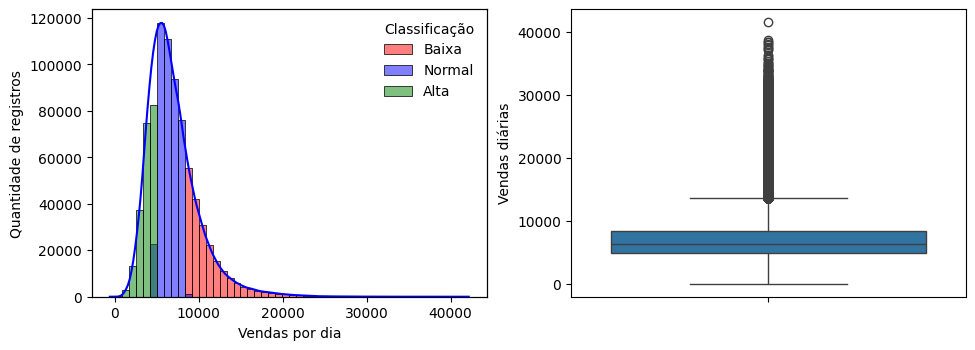

In [45]:
sales(df5)

In [50]:
print('Distribuição original das vendas diárias')
print('Assimetria: {}'.format(df5['sales'].skew().round(2))) 
print('Curtose: {}'.format(df5['sales'].kurt().round(2)))
print('--------------------------------')
print('Distribuição original do logaritmo das vendas diárias')
print('Assimetria: {}'.format(np.log1p(df5['sales']).skew().round(2))) 
print('Curtose: {}'.format(np.log1p(df5['sales']).kurt().round(2)))

Distribuição original das vendas diárias
Assimetria: 1.59
Curtose: 4.85
--------------------------------
Distribuição original do logaritmo das vendas diárias
Assimetria: -0.11
Curtose: 0.65


### Atributo: Customers

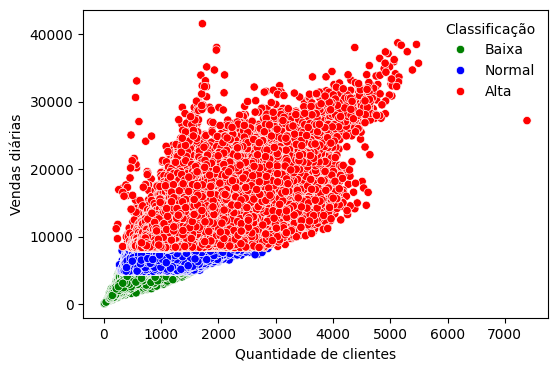

In [102]:
sales_customers(df5)

### Hipóteses

#### H1: Lojas com maior sortimento vendem mais.
<p p style="color:green"><strong>VERDADEIRA</strong></p>

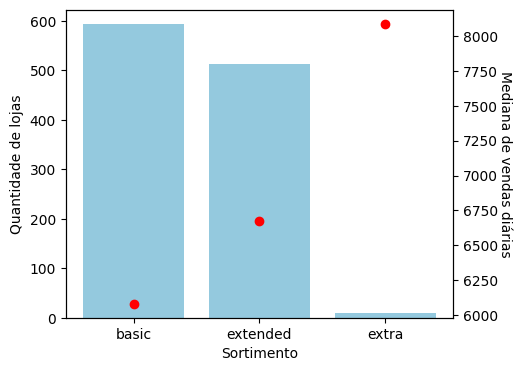

In [29]:
h1(df5)

#### H2: Lojas com maior quantidade de competidores próximos vendem menos.
<p p style="color:red"><strong>FALSA</strong></p>

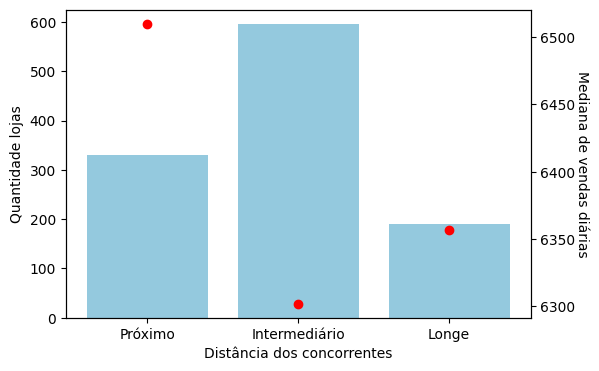

In [31]:
h2(df5)

#### H3: Lojas com concorrentes a mais tempo vendem mais.
<p p style="color:red"><strong>FALSA</strong></p>

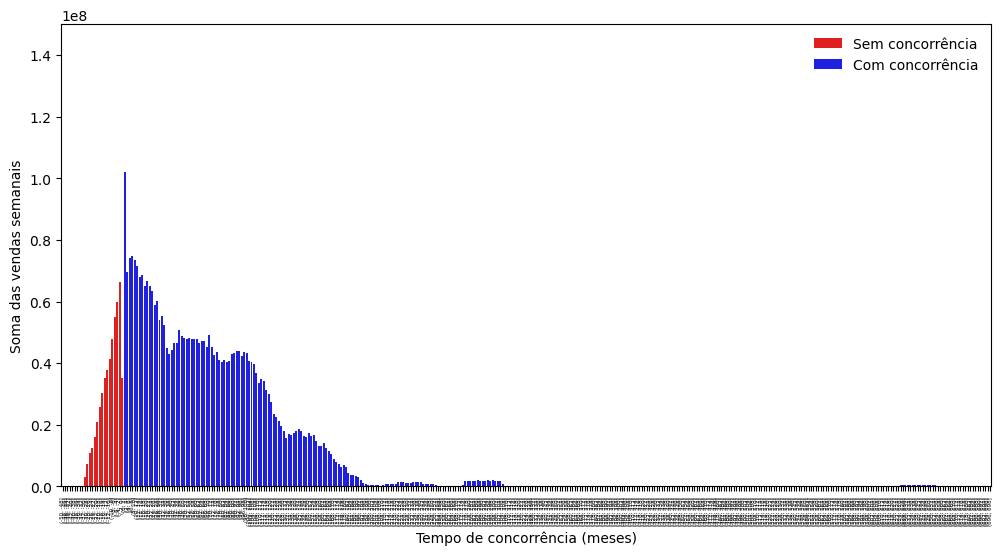

In [35]:
h3(df5)

#### H4: Lojas com promoções ativas por mais tempo vendem mais.
<p p style="color:red"><strong>FALSA</strong></p>

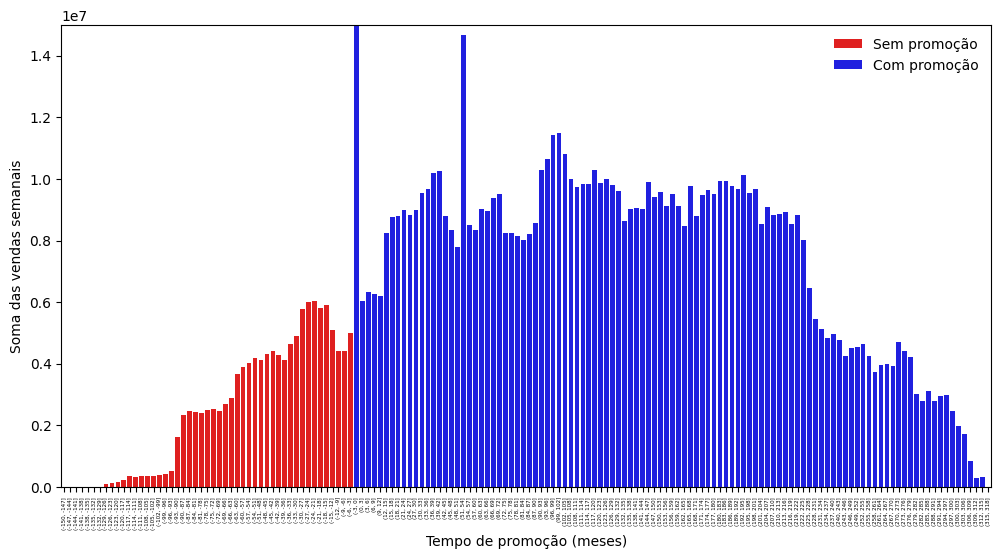

In [53]:
groups_bins_negativos, groups_bins_positivos2, groups_bins_positivos50 = h4(df5)

##### Série temporal das vendas ao longo de períodos promocionais (todas as lojas)

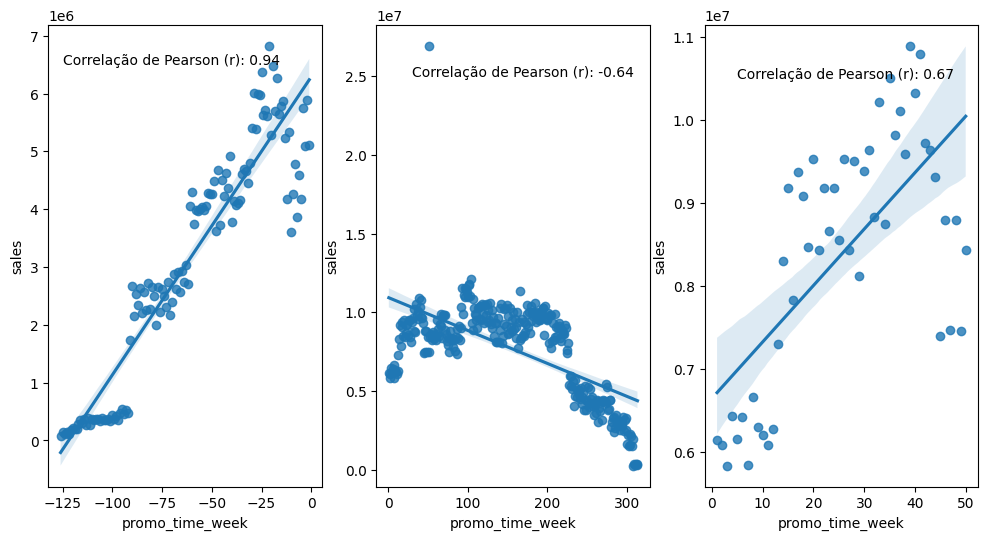

In [64]:
temporal_serie_sales(groups_bins_negativos, groups_bins_positivos2, groups_bins_positivos50)

##### Série temporal por loja (loja 500)

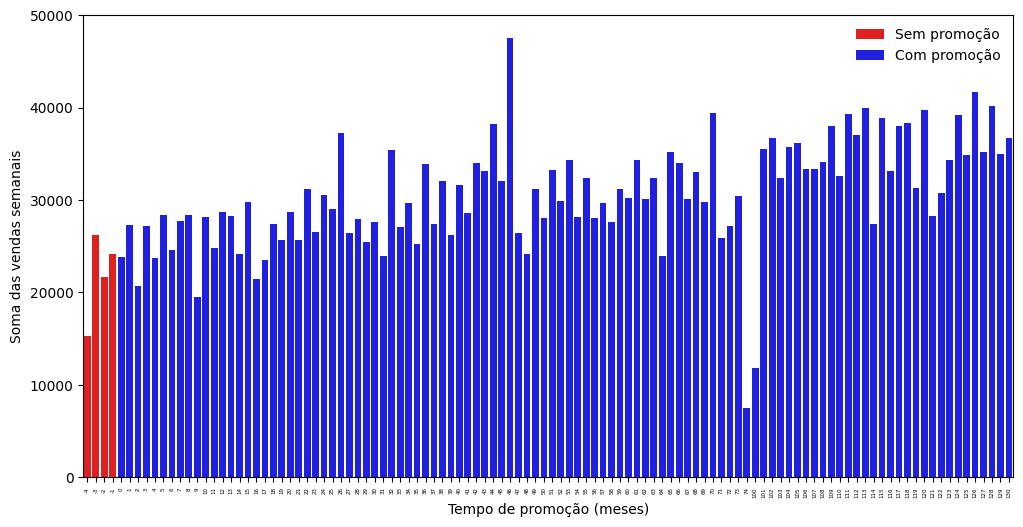

In [84]:
store = df5[['store', 'promo_time_week', 'sales']].copy()
store = store.loc[store['store'] == 500, :]
#----------------------------------------------------
promo_negativos = store[store['promo_time_week']<0] #Valores negativos nos bins: a venda foi efetuada antes do extensão da promoção
promo_positivos = store[store['promo_time_week']>=0]
#------------------------------------------------------
groups_bins_negativos     = promo_negativos[['promo_time_week', 'sales']].groupby('promo_time_week', observed=True).sum().reset_index()
groups_bins_negativos_median = promo_negativos[['promo_time_week', 'sales']].groupby('promo_time_week', observed=True).median().reset_index()
df_merge_negativos = groups_bins_negativos.merge(groups_bins_negativos_median, on = 'promo_time_week', how = 'inner')
#-------------------------------------------------------
groups_bins_positivos        = promo_positivos[['promo_time_week', 'sales']].groupby('promo_time_week', observed=True).sum().reset_index()
groups_bins_positivos2 = groups_bins_positivos.loc[1:, :]
groups_bins_positivos50 = groups_bins_positivos2[groups_bins_positivos2['promo_time_week']<=50]
groups_bins_positivos_median = promo_positivos[['promo_time_week', 'sales']].groupby('promo_time_week', observed=True).median().reset_index()
df_merge_positivos           = groups_bins_positivos.merge(groups_bins_positivos_median, on = 'promo_time_week', how = 'inner')
#-------------------------------------------------------
fig, ax = plt.subplots(figsize = (12,6))

sns.barplot(x = df_merge_negativos['promo_time_week'], y = df_merge_negativos['sales_x'], ax = ax, color = 'red', label = 'Sem promoção', errorbar = None)
sns.barplot(x = df_merge_positivos['promo_time_week'], y = df_merge_positivos['sales_x'], ax = ax, color = 'blue', label = 'Com promoção', errorbar = None)
ax.legend(frameon=False)
ax.set_ylim(0,50000)
ax.set_xlabel('Tempo de promoção (meses)')
ax.set_ylabel('Soma das vendas semanais')

ax.tick_params(axis='x', labelrotation=90, labelsize=4);

Text(5, 45000, 'Correlação de Pearson (r): 0.48')

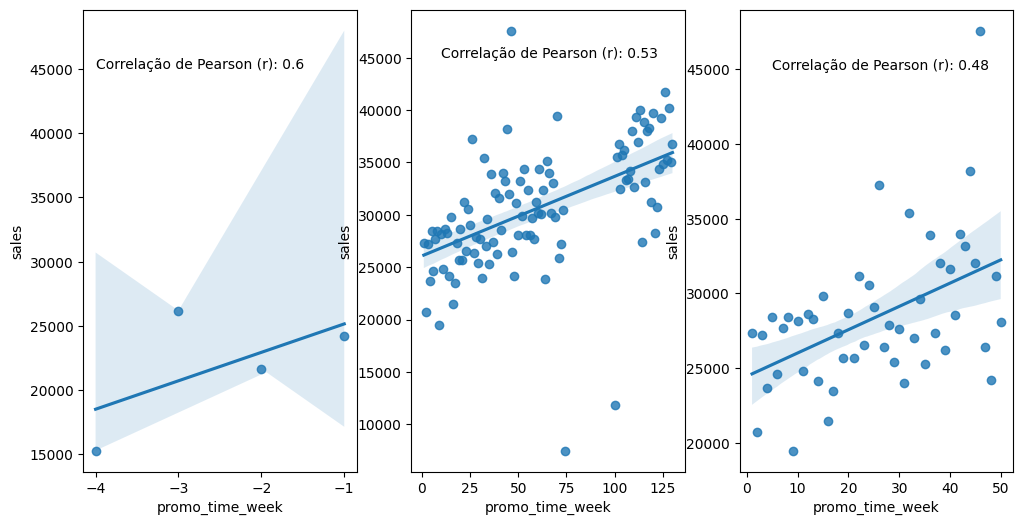

In [89]:
fig8, axs = plt.subplots(1,3, figsize = (12,6))

sns.regplot(x = 'promo_time_week', y = 'sales', data = groups_bins_negativos, ax = axs[0])
sns.regplot(x = 'promo_time_week', y = 'sales', data = groups_bins_positivos2, ax = axs[1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = groups_bins_positivos50, ax = axs[2])
#----------------------------------------------------------------------------------------------------
r1 = groups_bins_negativos[['promo_time_week', 'sales']].corr().round(2).iloc[1,0]
r2 = groups_bins_positivos[['promo_time_week', 'sales']].corr().round(2).iloc[1,0]
r3 = groups_bins_positivos50[['promo_time_week', 'sales']].corr().round(2).iloc[1,0]
#----------------------------------------------------------------------------------------------------
axs[0].annotate('Correlação de Pearson (r): {}'.format(r1), xy = (-4,45000))
axs[1].annotate('Correlação de Pearson (r): {}'.format(r2), xy = (10,45000))
axs[2].annotate('Correlação de Pearson (r): {}'.format(r3), xy = (5,45000))

#### H5: Lojas com mais dias de promoções consecutivas vendem mais.
<p p style="color:red"><strong>FALSA</strong></p>

In [39]:
print('Período das vendas: {} dias'.format(df5['date'].nunique()))

Período das vendas: 942 dias


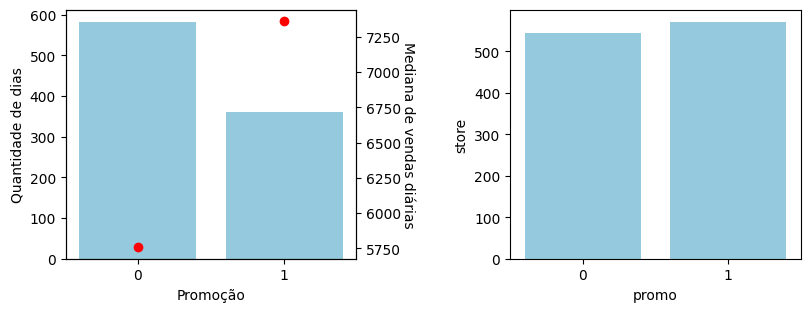

In [41]:
h5(df5)

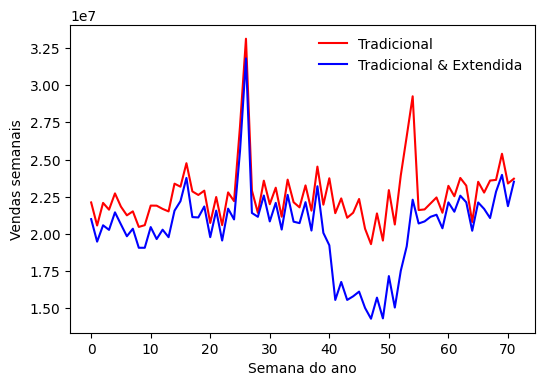

In [43]:
h5_series(df5)

#### H6: Lojas abertas durante o Natal vendem mais.
<p p style="color:green"><strong>VERDADEIRA</strong></p>

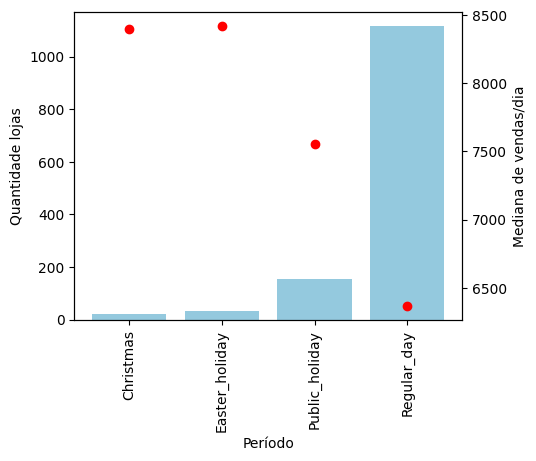

In [78]:
h6_natal(df5)

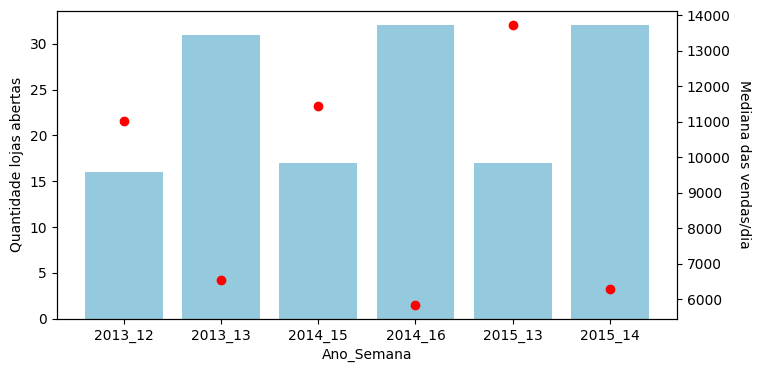

In [108]:
h6_pascoa(df5)

#### H7: As vendas das lojas cresceram ao longo do tempo.
<p p style="color:red"><strong>FALSA PARA ALGUNS MESES</strong></p>

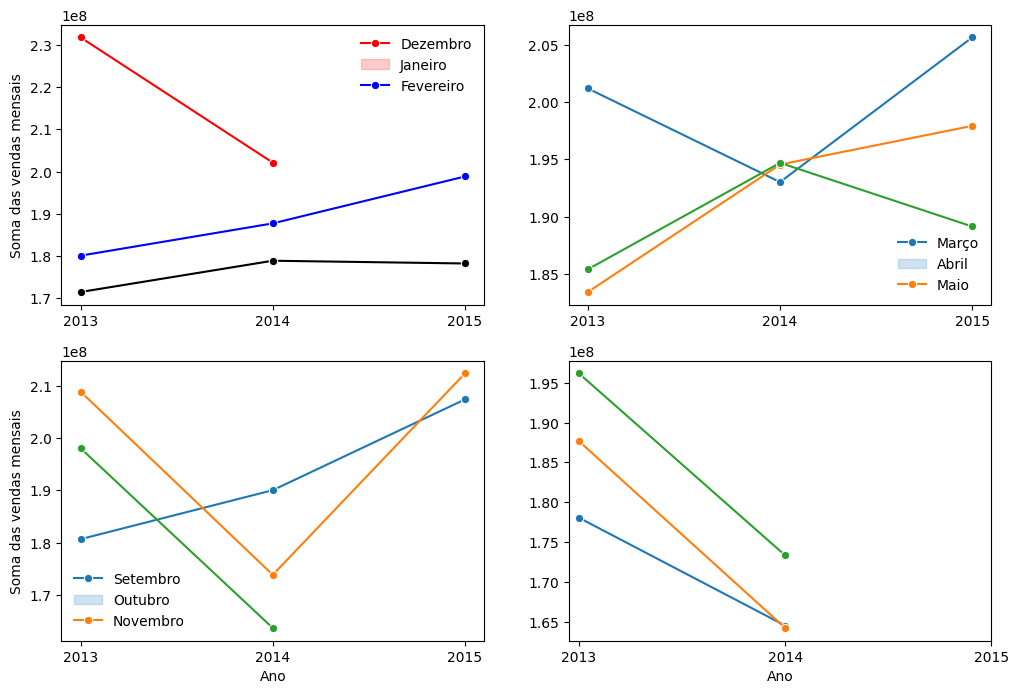

In [110]:
h7(df5)

#### H8: Lojas vendem mais no segundo semestre do ano.
<p p style="color:red"><strong>FALSA</strong></p>

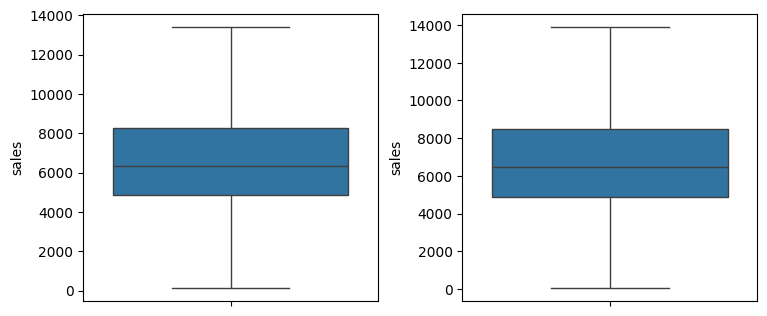

In [114]:
h8(df5)

#### H9: Lojas vendem mais após o dia 10 de cada mês.
<p p style="color:green"><strong>VERDADEIRA</strong></p>

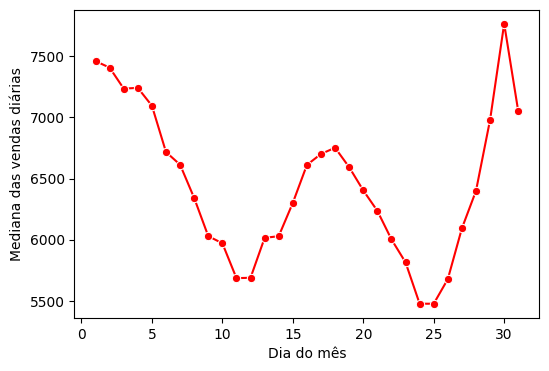

In [116]:
h9(df5)

#### H10: Lojas vendem menos nos finais de semana.
<p p style="color:green"><strong>VERDADEIRA</strong></p>

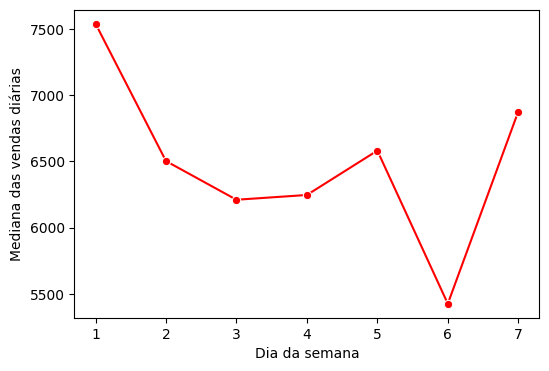

In [120]:
h10(df5)

#### H11: Lojas vendem menos durante feriados escolares.
<p p style="color:red"><strong>FALSA</strong></p>

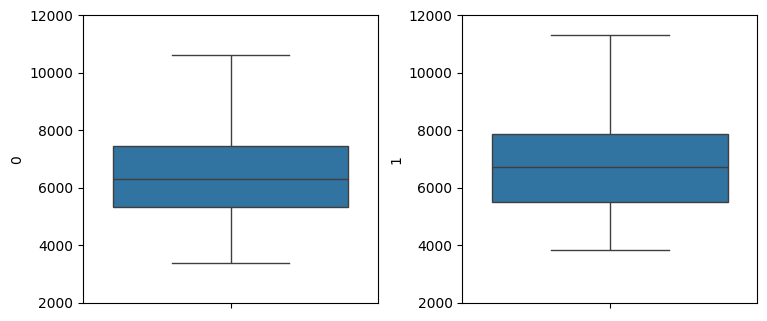

In [124]:
h11(df5)

### Análise bivariada

#### Qual a magnitude da relação entre as variáveis categóricas das lojas da Rossmann? 

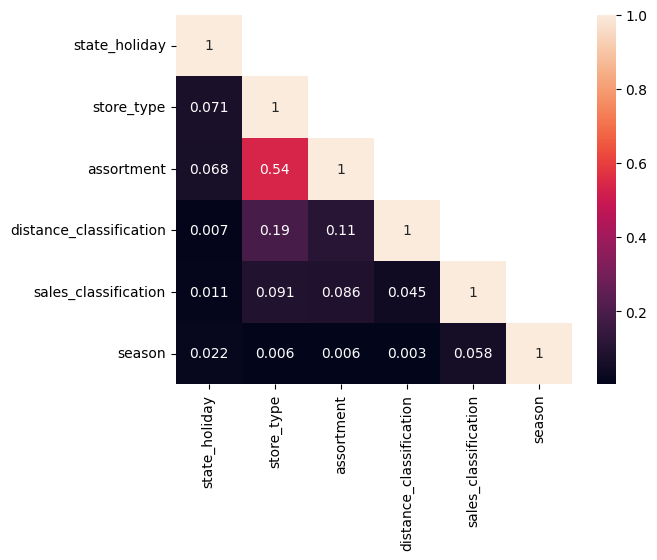

In [14]:
crosstab(df5)

#### A magnitude de relação entre as variáveis categóricas é a mesma para diferentes cenários de vendas diárias?

<p><strong>Cenário de venda</strong>:</p>

* Venda Baixa  - venda diária < € 4859
* Venda Normal - venda diária ≥ € 4859 e ≤ € 8360 
* Venda Alta   - venda diária > € 8360

<p><strong>Dataframes para análise</strong>: Original (todo conjunto de dados); Baixa, Normal e Alta após filtragem das linhas pelo critério acima indicado.</p>

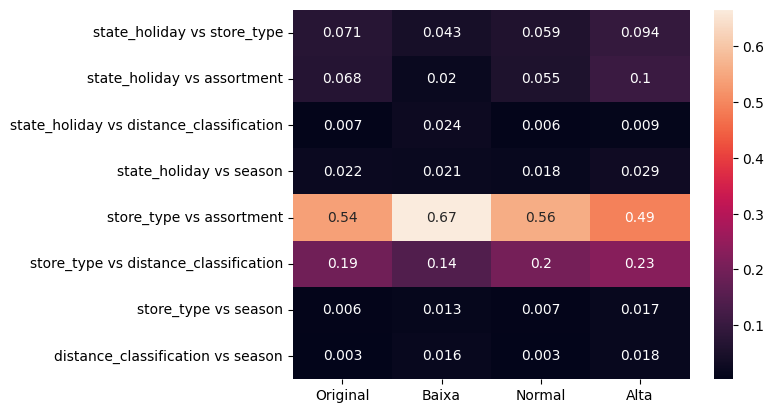

In [23]:
comparativo(df5)

# Passo 05: Preparação dos dados

## Function

In [2]:
def features_encoding_transformation(df1):

    df1 = df1.drop(['promo_since', 'competition_since'], axis = 1)

    #RESPONSE VARIABLE
    df1['sales_log'] = np.log1p(df1['sales'])
    df1['sales_boxcox'] = ss.boxcox(df5['sales'])[0]

    #CYCLIC VARIABLES
    ## 'day'
    df1['day_sin'] = df1['day'].apply(lambda x: np.sin(x * (2 * np.pi / 30 )))
    df1['day_cos'] = df1['day'].apply(lambda x: np.cos(x * (2 * np.pi / 30 )))

    ## 'day_of_week
    df1['day_of_week_sin'] = df1['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi / 7 )))
    df1['day_of_week_cos'] = df1['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi / 7 )))

    ## 'month'
    df1['month_sin'] = df1['month'].apply(lambda x: np.sin(x * (2 * np.pi / 12 )))
    df1['month_cos'] = df1['month'].apply(lambda x: np.cos(x * (2 * np.pi / 12 )))

    ## 'week_of_year'
    df1['week_of_year_sin'] = df1['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi / 52 )))
    df1['week_of_year_cos'] = df1['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi / 52 )))

    ## 'season'
    seasons = {'Spring': 1, 'Summer': 2, 'Fall': 3, 'Winter': 4}
    df1['season'] = df1['season'].map(seasons)
    df1['season_sin'] = df1['season'].apply(lambda x: np.sin(x * (2 * np.pi / 4 )))
    df1['season_cos'] = df1['season'].apply(lambda x: np.cos(x * (2 * np.pi / 4 )))

    cols_drop = ['day', 'day_of_week', 'month', 'season']
    df1 = df1.drop(cols_drop, axis = 1)

    #CATEGORICAL VARIABLES

    ## 'state_holiday'
    df1 = pd.get_dummies(df1, prefix = ['state_holiday'], columns = ['state_holiday'], dtype = int)

    ## 'store_type'
    le = LabelEncoder()
    df1['store_type'] = le.fit_transform(df1['store_type'])
    pickle.dump(le, open('parameters/store_type_scaler.pkl', 'wb'))

    ## 'assortment'
    assortment = {'basic': 1, 'extended': 2, 'extra': 3}
    df1['assortment'] = df1['assortment'].map(assortment)

    #NUMERICAL VARIABLES
    rs = RobustScaler() #Faz surgir valores negativos
    mms = MinMaxScaler()

    ## 'competition_distance'
    df1['competition_distance'] = mms.fit_transform(df1[['competition_distance']].values)
    pickle.dump(mms, open('parameters/competition_distance_scaler.pkl', 'wb'))

    ## 'competition_time_months'
    df1['competition_time_months'] = mms.fit_transform(df1[['competition_time_months']].values)
    pickle.dump(mms, open('parameters/competition_time_months_scaler.pkl', 'wb'))

    ## 'promo_time_week'
    df1['promo_time_week'] = mms.fit_transform(df1[['promo_time_week']].values)
    pickle.dump(mms, open('parameters/promo_time_week_scaler.pkl', 'wb'))

    ## 'year'
    df1['year'] = mms.fit_transform(df1[['year']].values)
    pickle.dump(mms, open('parameters/year_scaler.pkl', 'wb'))

    return df1
#---------------------------------------------------------------------------------------------------
def week_count(dataframe):

    weeks = ['2013-00', '2013-01', '2013-02', '2013-03', '2013-04', '2013-05',
       '2013-06', '2013-07', '2013-08', '2013-09', '2013-10', '2013-11',
       '2013-12', '2013-13', '2013-14', '2013-15', '2013-16', '2013-17',
       '2013-18', '2013-19', '2013-20', '2013-21', '2013-22', '2013-23',
       '2013-24', '2013-25', '2013-26', '2013-27', '2013-28', '2013-29',
       '2013-30', '2013-31', '2013-32', '2013-33', '2013-34', '2013-35',
       '2013-36', '2013-37', '2013-38', '2013-39', '2013-40', '2013-41',
       '2013-42', '2013-43', '2013-44', '2013-45', '2013-46', '2013-47',
       '2013-48', '2013-49', '2013-50', '2013-51', '2013-52', '2014-00',
       '2014-01', '2014-02', '2014-03', '2014-04', '2014-05', '2014-06',
       '2014-07', '2014-08', '2014-09', '2014-10', '2014-11', '2014-12',
       '2014-13', '2014-14', '2014-15', '2014-16', '2014-17', '2014-18',
       '2014-19', '2014-20', '2014-21', '2014-22', '2014-23', '2014-24',
       '2014-25', '2014-26', '2014-27', '2014-28', '2014-29', '2014-30',
       '2014-31', '2014-32', '2014-33', '2014-34', '2014-35', '2014-36',
       '2014-37', '2014-38', '2014-39', '2014-40', '2014-41', '2014-42',
       '2014-43', '2014-44', '2014-45', '2014-46', '2014-47', '2014-48',
       '2014-49', '2014-50', '2014-51', '2014-52', '2015-00', '2015-01',
       '2015-02', '2015-03', '2015-04', '2015-05', '2015-06', '2015-07',
       '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2015-13',
       '2015-14', '2015-15', '2015-16', '2015-17', '2015-18', '2015-19',
       '2015-20', '2015-21', '2015-22', '2015-23', '2015-24']

    X_train2 = pd.DataFrame()
    number_of_week = 0

    for week in weeks:
    
        df = X_train[X_train['year_week'] == week].copy()
        df['year_week'] = number_of_week
        X_train2 = pd.concat([df, X_train2], axis=0)
        number_of_week += 1

    return X_train2
#---------------------------------------------------------------------------------------------------
def split_dataframe(df1):

    last_6_weeks = df1[['year_week', 'date']].groupby('year_week').agg(['min', 'max', 'nunique']).reset_index().tail(6)['year_week'].tolist()

    X_train = df6[(df6['year_week'] != '2015-25')&
                  (df6['year_week'] != '2015-26')&
                  (df6['year_week'] != '2015-27')&
                  (df6['year_week'] != '2015-28')&
                  (df6['year_week'] != '2015-29')&
                  (df6['year_week'] != '2015-30')]

    X_test = df6[(df6['year_week'] == '2015-25')|
                 (df6['year_week'] == '2015-26')|
                 (df6['year_week'] == '2015-27')|
                 (df6['year_week'] == '2015-28')|
                 (df6['year_week'] == '2015-29')|
                 (df6['year_week'] == '2015-30')]

    return X_train, X_test

## Steps

In [2]:
df5 = pd.read_csv('../datasets/df5.csv')

In [4]:
df6 = features_encoding_transformation(df5)
print(df6.columns)

Index(['store', 'date', 'sales', 'customers', 'promo', 'school_holiday',
       'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo',
       'distance_classification', 'sales_classification', 'year', 'year_week',
       'week_of_year', 'competition_time_months', 'promo_time_week',
       'sales_log', 'sales_boxcox', 'day_sin', 'day_cos', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'week_of_year_sin',
       'week_of_year_cos', 'season_sin', 'season_cos',
       'state_holiday_Christmas', 'state_holiday_Easter_holiday',
       'state_holiday_Public_holiday', 'state_holiday_Regular_day'],
      dtype='object')


In [5]:
df6.shape

(844338, 38)

In [6]:
X_train, X_test = split_dataframe(df6)
print(X_train.shape)
print(X_test.shape)

(805202, 38)
(39136, 38)


In [8]:
X_train2 = week_count(X_train)
X_train2.shape

(805202, 38)

In [9]:
X_train2.to_csv('datasets/X_train.csv', index = False)
X_test.to_csv('datasets/X_test.csv', index = False)

# Passo 06: Seleção de variáveis com algoritmo Boruta

In [9]:
cols = ['competition_distance', 'competition_time_months', 'promo_time_week',
        'store', 'store_type', 'assortment',
        'state_holiday_Christmas', 'state_holiday_Easter_holiday', 'state_holiday_Public_holiday', 'state_holiday_Regular_day',
        'promo', 'promo2',
        'day_sin', 'day_cos', 
        'day_of_week_sin', 'day_of_week_cos',
        'month_sin', 'month_cos',
        'week_of_year_sin', 'week_of_year_cos',
        'season_sin', 'season_cos']

x_train = X_train[cols].head(50000) #Limitação devido à capacidade de processamento da máquina
y_train = X_train['sales_log'].head(50000)

In [10]:
rf = RandomForestRegressor(n_jobs = -1)

boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(x_train, y_train.values.ravel())

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	9
Tentative: 	0
Rejected: 	13


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	9
Tentative: 	0
Rejected: 	13


In [11]:
cols_boruta = boruta.support_.tolist() #True or False
cols_selected = x_train.iloc[:, cols_boruta].columns.tolist()
cols_not_selected = np.setdiff1d(cols, cols_selected).tolist()

In [12]:
print(cols_boruta)

[True, True, True, True, True, True, False, False, False, False, True, False, False, True, False, True, False, False, False, False, False, False]


In [13]:
print(cols_selected)

['competition_distance', 'competition_time_months', 'promo_time_week', 'store', 'store_type', 'assortment', 'promo', 'day_cos', 'day_of_week_cos']


In [14]:
print(cols_not_selected)

['day_of_week_sin', 'day_sin', 'month_cos', 'month_sin', 'promo2', 'season_cos', 'season_sin', 'state_holiday_Christmas', 'state_holiday_Easter_holiday', 'state_holiday_Public_holiday', 'state_holiday_Regular_day', 'week_of_year_cos', 'week_of_year_sin']


# Passo 07: Ajuste de modelos de *machine learning*

In [2]:
X_train = pd.read_csv('datasets/X_train.csv')
X_test = pd.read_csv('datasets/X_test.csv')

In [3]:
X_train.columns

Index(['store', 'date', 'sales', 'customers', 'promo', 'school_holiday',
       'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo',
       'distance_classification', 'sales_classification', 'year', 'year_week',
       'week_of_year', 'competition_time_months', 'promo_time_week',
       'sales_log', 'sales_boxcox', 'day_sin', 'day_cos', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'week_of_year_sin',
       'week_of_year_cos', 'season_sin', 'season_cos',
       'state_holiday_Christmas', 'state_holiday_Easter_holiday',
       'state_holiday_Public_holiday', 'state_holiday_Regular_day'],
      dtype='object')

In [4]:
#Inseridas features da análsie de Meigarom
cols_selected = ['competition_distance',
                 'competition_time_months',
                 'promo_time_week',
                 'store',
                 'store_type',
                 'assortment',
                 'promo', 
                 'promo2',
                 'day_sin',
                 'day_cos',
                 'day_of_week_sin',
                 'day_of_week_cos',
                 'week_of_year_cos',
                 'week_of_year_sin',
                 'month_sin',
                 'month_cos']

cols_selected.extend(['date', 'year_week', 'sales_log'])

x_train = X_train[cols_selected].copy()
x_test = X_test[cols_selected].copy()
y_train = X_train['sales_log']
y_test = X_test['sales_log']

In [5]:
x_train.shape

(805202, 19)

## 7.1) Functions

In [12]:
def ml_error(model, sales, prediction):

    mae = round(mean_absolute_error(sales, prediction),2)
    
    mape = int(100*round(mean_absolute_percentage_error(sales, prediction),2))
    
    mse = round(mean_squared_error(sales, prediction),2)

    rmse = round(np.sqrt(mse),2)

    return pd.DataFrame({'Model': model,
                         'MAE': mae, 
                         'MAPE': mape, 
                         'MSE': mse, 
                         'RMSE': rmse}, index = [0])
#-------------------------------------------------------------------------------------
def cross_validation_avg(dataframe, average):

    df = pd.DataFrame()

    for k in range(9,22):

        training = dataframe[dataframe['year_week'] < 6*k]
        test     = dataframe[dataframe['year_week'] >= 6*k]

        count_train = dataframe[dataframe['year_week'] < 6*k]['year_week'].nunique()
        count_test = dataframe[dataframe['year_week'] >= 6*k]['year_week'].nunique()
    
        model_avg = training[['store', 'sales_log']].groupby('store').mean().reset_index().rename(columns = {'sales_log': 'prediction'})

        test_avg = test[['store', 'sales_log']].copy()
        model = pd.merge(test_avg, model_avg, on = 'store', how = 'right')

        model_error = ml_error('Average_Model', np.expm1(model['sales_log']), np.expm1(model['prediction']))
    
        df1 = pd.DataFrame({'k': k,
                            'Treino': count_train,
                            'Teste': count_test,
                            'MAE': model_error['MAE'],
                            'MAPE': model_error['MAPE'],
                            'RMSE': model_error['RMSE']
                           })

        df = pd.concat([df, df1], axis = 0)

    return pd.DataFrame({'k_folds': [df['k'].nunique()],
                         'MAE_Avg': [round(df['MAE'].mean(),2)],
                         'MAE_Std': [round(df['MAE'].std(),2)],
                         #'MAPE_Avg': round(df['MAPE'].mean(),2),
                         #'MAPE_Std': round(df['MAPE'].std(),2),
                         'RMSE_Avg': [round(df['RMSE'].mean(),2)],
                         'RMSE_Std': [round(df['RMSE'].std(),2)]}, index = [average])
#-------------------------------------------------------------------------------------
def cross_validation_linear(dataframe, MachineLearning, model):

    reg_model = MachineLearning()
    df2 = pd.DataFrame()

    for k in range(9,22):

            training = dataframe[dataframe['year_week'] < 6*k]
            test     = dataframe[dataframe['year_week'] >= 6*k]

            reg_model.fit(training.drop(['date', 'year_week', 'sales_log'], axis=1), training['sales_log'])
    
            prediction = reg_model.predict(test.drop(['date', 'year_week', 'sales_log'], axis=1))

            errors = ml_error('Linear Model', np.expm1(test['sales_log']), np.expm1(prediction))
    
            df1 = pd.DataFrame({'k_folds': k,
                                'MAE': errors['MAE'],
                                'MAPE': errors['MAPE'],
                                'RMSE': errors['RMSE']
                               })

            df2 = pd.concat([df2, df1], axis = 0)

    return pd.DataFrame({'k_folds': [df2['k_folds'].nunique()],
                         'MAE_Avg': [round(df2['MAE'].mean(),2)],
                         'MAE_Std': [round(df2['MAE'].std(),2)],
                         #'MAPE_Avg': round(df['MAPE'].mean(),2),
                         #'MAPE_Std': round(df['MAPE'].std(),2),
                         'RMSE_Avg': [round(df2['RMSE'].mean(),2)],
                         'RMSE_Std': [round(df2['RMSE'].std(),2)]}, index = [model])
#-------------------------------------------------------------------------------------
def cross_validation_rf(dataframe, model):

    rf = RandomForestRegressor(n_estimators = 10)
    df2 = pd.DataFrame()

    for k in range(9,14):

        print(k)        

        training = dataframe[dataframe['year_week'] < 6*k]
        test     = dataframe[dataframe['year_week'] >= 6*k]

        rf.fit(training.drop(['date', 'year_week', 'sales_log'], axis=1), training['sales_log'].values.ravel())
    
        prediction = rf.predict(test.drop(['date', 'year_week', 'sales_log'], axis=1))

        errors = ml_error('RandomForest', np.expm1(test['sales_log']), np.expm1(prediction))
    
        df1 = pd.DataFrame({'k_folds': k,
                            'MAE': errors['MAE'],
                            'MAPE': errors['MAPE'],
                            'RMSE': errors['RMSE']
                            })

        df2 = pd.concat([df2, df1], axis = 0)

    return pd.DataFrame({'k_folds': [df2['k_folds'].nunique()],
                         'MAE_Avg': [round(df2['MAE'].mean(),2)],
                         'MAE_Std': [round(df2['MAE'].std(),2)],
                         #'MAPE_Avg': round(df['MAPE'].mean(),2),
                         #'MAPE_Std': round(df['MAPE'].std(),2),
                         'RMSE_Avg': [round(df2['RMSE'].mean(),2)],
                         'RMSE_Std': [round(df2['RMSE'].std(),2)]}, index = [model])
#-------------------------------------------------------------------------------------
def cross_validation_xgb(dataframe, model):

    xgb_ = xgb.XGBRegressor(objective = 'reg:squarederror',
                            n_estimators=10,
                            eta = 0.01,
                            max_depth = 10,
                            subsample = 0.7)
    df2 = pd.DataFrame()

    for k in range(9,14):

        training = dataframe[dataframe['year_week'] < 6*k]
        test     = dataframe[dataframe['year_week'] >= 6*k]

        xgb_.fit(training.drop(['date', 'year_week', 'sales_log'], axis=1), training['sales_log'].values.ravel())
    
        prediction = xgb_.predict(test.drop(['date', 'year_week', 'sales_log'], axis=1))

        errors = ml_error('XGB', np.expm1(test['sales_log']), np.expm1(prediction))
    
        df1 = pd.DataFrame({'k_folds': k,
                            'MAE': errors['MAE'],
                            'MAPE': errors['MAPE'],
                            'RMSE': errors['RMSE']
                            })

        df2 = pd.concat([df2, df1], axis = 0)

    return pd.DataFrame({'k_folds': [df2['k_folds'].nunique()],
                         'MAE_Avg': [round(df2['MAE'].mean(),2)],
                         'MAE_Std': [round(df2['MAE'].std(),2)],
                         #'MAPE_Avg': round(df['MAPE'].mean(),2),
                         #'MAPE_Std': round(df['MAPE'].std(),2),
                         'RMSE_Avg': [round(df2['RMSE'].mean(),2)],
                         'RMSE_Std': [round(df2['RMSE'].std(),2)]}, index = [model])

## 7.2) Steps

### 7.2.1) Average Model

In [25]:
#Criando o modelo baseado na média sobre conjunto de treinamento
model_avg = x_train[['store']].copy()
model_avg['sales_log'] = y_train.copy() #Dados logaritmizados
model_avg = model_avg[['store', 'sales_log']].groupby('store').mean().reset_index().rename(columns = {'sales_log': 'prediction'})

#Unindo predição e valor observado no conjunto de teste
test_avg = x_test[['store']].copy()
test_avg['sales_log'] = y_test.copy()

#Avaliando a performance do modelo
aux1 = test_avg.merge(model_avg, how = 'left', on = 'store')
avg_model_erros = ml_error('Average_Model', np.expm1(aux1['sales_log']), np.expm1(aux1['prediction']))
avg_model_erros

,Model,MAE,MAPE,MSE,RMSE
0,Average_Model,1440.03,22,3829360.43,1956.88


#### Cross validation - average model

In [33]:
cross_validation_avg(x_train, 'Average')

,k_folds,MAE_Avg,MAE_Std,RMSE_Avg,RMSE_Std
Average,13,1507.2,47.25,2056.39,78.97


### 7.2.2) Modelo de Regressão Linear

In [36]:
lr = LinearRegression()

lr.fit(x_train.drop(['date', 'year_week', 'sales_log'], axis=1), y_train)

lr_prediction = lr.predict(x_test.drop(['date', 'year_week', 'sales_log'], axis=1))

lr_erros = ml_error('Linear Regression', np.expm1(y_test), np.expm1(lr_prediction))

avg_model_erros = pd.concat([avg_model_erros, lr_erros])
avg_model_erros

,Model,MAE,MAPE,MSE,RMSE
0,Average_Model,1440.03,22,3829360.43,1956.88
0,Linear Regression,1873.89,28,7399358.82,2720.18


#### Cross validation - linear regression

In [13]:
cross_validation_linear(x_train, LinearRegression, 'LinearRegression')

,k_folds,MAE_Avg,MAE_Std,RMSE_Avg,RMSE_Std
LinearRegression,13,2000.6,32.53,2889.99,54.85


### 7.2.3) Modelo de Regressão regularizado - Lasso

In [37]:
lasso = Lasso(alpha = 0.01)

lasso.fit(x_train.drop(['date', 'year_week', 'sales_log'], axis=1), y_train)

lasso_prediction = lasso.predict(x_test.drop(['date', 'year_week', 'sales_log'], axis=1))

lasso_erros = ml_error('Lasso', np.expm1(y_test), np.expm1(lasso_prediction))

avg_model_erros = pd.concat([avg_model_erros, lasso_erros])
avg_model_erros

,Model,MAE,MAPE,MSE,RMSE
0,Average_Model,1440.03,22,3829360.43,1956.88
0,Linear Regression,1873.89,28,7399358.82,2720.18
0,Lasso,1900.39,28,7703660.46,2775.55


#### Cross validation - regularized regression - lasso

In [18]:
cross_validation_linear(x_train, Lasso, 'Lasso')

,k_folds,MAE_Avg,MAE_Std,RMSE_Avg,RMSE_Std
Lasso,13,2281.81,35.78,3254.51,58.37


### 7.2.4) Modelo de Regressão regularizado - Ridge

In [38]:
ridge = Ridge(alpha = 0.01)

ridge.fit(x_train.drop(['date', 'year_week', 'sales_log'], axis=1), y_train)

ridge_prediction = ridge.predict(x_test.drop(['date', 'year_week', 'sales_log'], axis=1))

ridge_erros = ml_error('Ridge', np.expm1(y_test), np.expm1(ridge_prediction))

avg_model_erros = pd.concat([avg_model_erros, ridge_erros])
avg_model_erros

,Model,MAE,MAPE,MSE,RMSE
0,Average_Model,1440.03,22,3829360.43,1956.88
0,Linear Regression,1873.89,28,7399358.82,2720.18
0,Lasso,1900.39,28,7703660.46,2775.55
0,Ridge,1873.89,28,7399358.95,2720.18


#### Cross validation - regularized regression - ridge

In [19]:
cross_validation_linear(x_train, Ridge, 'Ridge')

,k_folds,MAE_Avg,MAE_Std,RMSE_Avg,RMSE_Std
Ridge,13,2000.6,32.53,2889.99,54.85


### 7.2.5) Random Forest Regressor

In [8]:
rf = RandomForestRegressor(n_estimators = 10)

rf.fit(x_train.drop(['date', 'year_week', 'sales_log'], axis=1), y_train.values.ravel())

rf_prediction = rf.predict(x_test.drop(['date', 'year_week', 'sales_log'], axis=1))

rf_erros = ml_error('RandomForestRegressor', np.expm1(y_test), np.expm1(rf_prediction))
rf_erros

,Model,MAE,MAPE,MSE,RMSE
0,RandomForestRegressor,774.93,11,1373495.8,1171.96


#### Cross validation - Random Forest

In [11]:
cross_validation_rf(x_train, 'RandomForest')

9
10
11
12
13


,k_folds,MAE_Avg,MAE_Std,RMSE_Avg,RMSE_Std
RandomForest,5,1078.4,53.46,1657.02,84.08


### 7.2.6) XGBoost

In [9]:
xgb_ = xgb.XGBRegressor(objective = 'reg:squarederror',
                       n_estimators=10,
                       eta = 0.01,
                       max_depth = 10,
                       subsample = 0.7)

xgb_.fit(x_train.drop(['date', 'year_week', 'sales_log'], axis=1), y_train.values.ravel())

xgb_prediction = xgb_.predict(x_test.drop(['date', 'year_week', 'sales_log'], axis=1))

xgb_errors = ml_error('XGBoost', np.expm1(y_test), np.expm1(xgb_prediction))

xgb_errors

,Model,MAE,MAPE,MSE,RMSE
0,XGBoost,2121.27,32,9147256.08,3024.44


#### Cross validation - XGB

In [9]:
cross_validation_xgb(x_train, 'XGB')

,k_folds,MAE_Avg,MAE_Std,RMSE_Avg,RMSE_Std
XGB,5,2197.3,13.64,3147.96,24.16


## Passo 07.1: Ajuste dos hiperparâmetros do modelo

In [6]:
param = {'n_estimators':     [1500, 1700, 2500, 3000, 3500], 
         'eta':              [0.01, 0.03],
         'max_depth':        [3, 5, 9],
         'subsample':        [0.1, 0.5, 0.7],
         'min_child_weight': [3, 8, 15]}

MAX_EVAL = 3

In [18]:
df = pd.DataFrame()

for i in range(MAX_EVAL):

    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}

    print(hp)

    model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                                 n_estimators = hp['n_estimators'],
                                 eta = hp['eta'],
                                 max_depth = hp['max_depth'],
                                 subsample = hp['subsample'],
                                 min_child_weight = hp['min_child_weight'])

    model_xgb.fit(x_train.drop(['date', 'year_week', 'sales_log'], axis=1), y_train.values.ravel())

    xgb_prediction = model_xgb.predict(x_test.drop(['date', 'year_week', 'sales_log'], axis=1))

    xgb_errors = ml_error('XGBoost', np.expm1(y_test), np.expm1(xgb_prediction))

    df = pd.concat([df, xgb_errors])

{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'min_child_weight': 3}
{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.5, 'min_child_weight': 3}
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'min_child_weight': 8}


In [19]:
df

,Model,MAE,MAPE,MSE,RMSE
0,XGBoost,1165.68,17,2954613.75,1718.90
0,XGBoost,839.82,12,1554865.98,1246.94
0,XGBoost,715.65,10,1113819.81,1055.38


In [7]:
xgb_model = xgb.XGBRegressor(random_state = 42)

random_search = RandomizedSearchCV(estimator = xgb_model,
                                   param_distributions = param,
                                   n_iter=1,  # Number of parameter settings that are sampled
                                   cv=2,       # Number of cross-validation folds
                                   scoring = 'neg_mean_squared_error', # Or other relevant regression metric
                                   random_state = 42, # Set random_state for reproducibility
                                   n_jobs = -1, verbose = 2)   # Use all available CPU cores

random_search.fit(x_train.drop(['date', 'year_week', 'sales_log'], axis=1), y_train.values.ravel())

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END eta=0.01, max_depth=9, min_child_weight=3, n_estimators=3500, subsample=0.1; total time=14.9min
[CV] END eta=0.01, max_depth=9, min_child_weight=3, n_estimators=3500, subsample=0.1; total time=14.9min


RandomizedSearchCV(cv=2,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=1, n_jobs=-1,
                   param_distributions={'eta': [0.01, 0.03],
                                        'max_depth': [3, 5, 9],
                                        'min_child_weight': [3, 8, 15],
                                        'n_estimators': [1500, 1700, 2500, 3000,
                                                         3500],
                                        'subsample': [0.1, 0.5, 0.7]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

### Best Parameters

In [12]:
best_parameters = {'n_estimators': 500, #Primeiro análise: n_estimators = 3500; segunda: 500
                   'eta': 0.01, 
                   'max_depth': 9,
                   'subsample': 0.7,
                   'min_child_weight': 3}

best_xgb_model = xgb.XGBRegressor(objective = 'reg:squarederror',
                                 n_estimators = best_parameters['n_estimators'],
                                 eta = best_parameters['eta'],
                                 max_depth = best_parameters['max_depth'],
                                 subsample = best_parameters['subsample'],
                                 min_child_weight = best_parameters['min_child_weight'])

best_xgb_model.fit(x_train.drop(['date', 'year_week', 'sales_log'], axis=1), y_train.values.ravel())
best_xgb_prediction = best_xgb_model.predict(x_test.drop(['date', 'year_week', 'sales_log'], axis=1))
xgb_errors = ml_error('XGBoost', np.expm1(y_test), np.expm1(best_xgb_prediction))
xgb_errors

,Model,MAE,MAPE,MSE,RMSE
0,XGBoost,1328.57,19,3816406.68,1953.56


In [14]:
pickle.dump(best_xgb_model, open('models/model_rossmann2.pkl', 'wb'))

# Passo 08: Interpretação a performance e erro do modelo ajustado

## 8.1) Functions

In [20]:
def errors(dataframe):

    fig, axs = plt.subplots(2,2, figsize = (10,8))
    fig.tight_layout(pad=2.5)

    sns.lineplot(x = dataframe['date'], y = dataframe['sales'], ax = axs[0,0])
    sns.lineplot(x = dataframe['date'], y = dataframe['prediction'], ax = axs[0,0])

    sns.lineplot(x = dataframe['date'], y = dataframe['error_rate'], ax = axs[0,1])
    axs[0,1].axhline(1, linestyle='--')

    sns.histplot(dataframe['error'], ax = axs[1,0])

    sns.scatterplot(x = dataframe['prediction'], y = dataframe['error'], ax = axs[1,1])
#---------------------------------------------------------------------------------------
def store_performance(dataframe):

    store_performance = dataframe[['store', 'sales', 'prediction']].groupby(['store']).sum().reset_index()
    #----------------------------------------------------------------------------------------------------------
    aux1 = dataframe[['store', 'sales', 'prediction']].groupby('store').apply(lambda x: ml_error('', x['sales'], x['prediction']), include_groups=False).reset_index().drop(['level_1', 'Model'], axis = 1)[['store', 'MAPE']]
    aux2 = dataframe[['store', 'sales', 'prediction']].groupby('store').apply(lambda x: ml_error('', x['sales'], x['prediction']), include_groups=False).reset_index().drop(['level_1', 'Model'], axis = 1)[['store', 'MAE']].astype(np.int64)
    aux3 = pd.merge(aux1, aux2, how = 'inner', on = 'store')
    #----------------------------------------------------------------------------------------------------------
    dataframe = pd.merge(dataframe, aux3, how = 'inner', on = 'store').sort_values('MAPE', ascending=False).reset_index(drop=True)
    #----------------------------------------------------------------------------------------------------------
    dataframe['worst_scenario'] = dataframe['prediction'] - dataframe['MAE']
    dataframe['best_scenario'] = dataframe['prediction'] + dataframe['MAE']
    
    return dataframe

def graph_errors(dataframe):

    sns.scatterplot(x = dataframe['store'], y = dataframe['MAPE'])
    plt.axhline(20, linestyle='--', color = 'red');  

## 8.2) Steps

In [6]:
model = pickle.load(open('models/model_rossmann2.pkl', 'rb'))
best_prediction = model.predict(x_test.drop(['date', 'year_week', 'sales_log'], axis=1))
best_prediction.shape

(39136,)

In [7]:
df_error = x_test[['store', 'date']].copy()
df_error['sales'] = np.expm1(y_test).astype(np.int64).copy() 
df_error['prediction'] = np.expm1(best_prediction).astype(np.int64) 
df_error['error'] = df_error['sales'] - df_error['prediction']
df_error['error_rate'] = df_error['prediction'] / df_error['sales']
df_error['mpe'] = round((df_error['sales'] - df_error['prediction'])/df_error['sales'],3)
round(df_error['mpe'].mean(),3)

np.float64(-0.005)

### Avaliação do erro

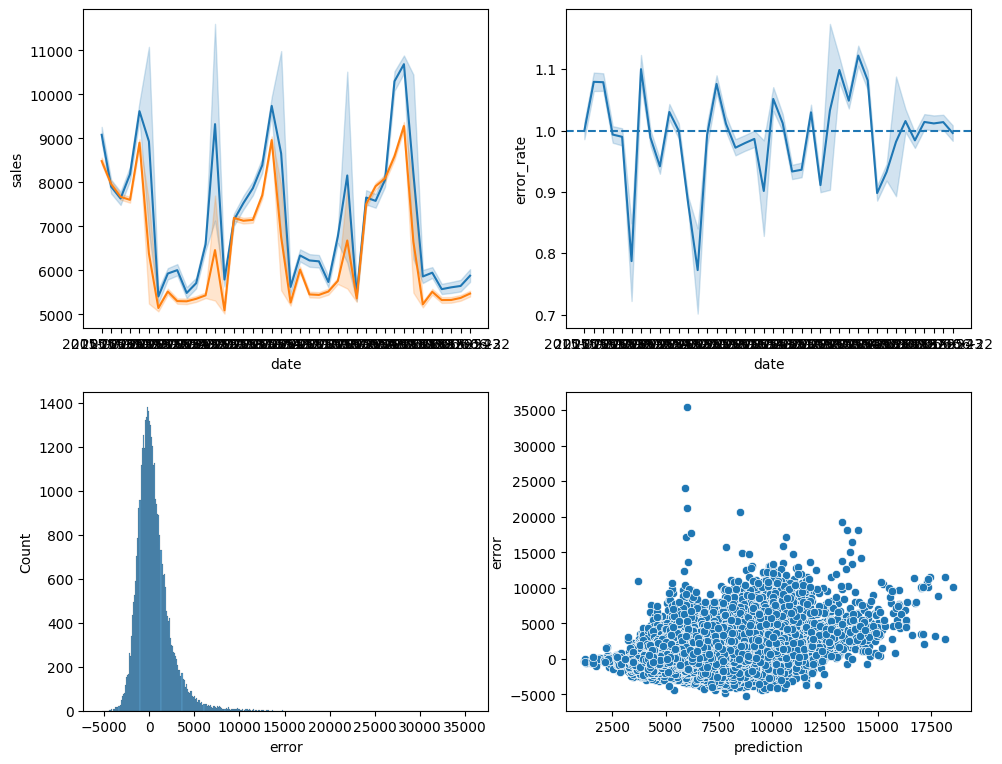

In [9]:
errors(df_error)

### Performance de Negócio

In [23]:
store_performance = store_performance(df_error)
store_performance

,store,date,sales,prediction,error,error_rate,mpe,MAPE,MAE,worst_scenario,best_scenario
0,543,2015-07-16,3477,5874,-2397,1.689387,-0.689,101,2389,3485,8263
1,543,2015-06-23,2048,3671,-1623,1.792480,-0.792,101,2389,1282,6060
2,543,2015-07-01,2553,6816,-4263,2.669800,-1.670,101,2389,4427,9205
3,543,2015-07-15,3530,5904,-2374,1.672521,-0.673,101,2389,3515,8293
4,543,2015-07-29,3485,6456,-2971,1.852511,-0.853,101,2389,4067,8845
...,...,...,...,...,...,...,...,...,...,...,...
39131,280,2015-07-28,7783,6970,813,0.895542,0.104,6,414,6556,7384
39132,311,2015-07-28,8925,8372,553,0.938039,0.062,6,451,7921,8823
39133,311,2015-07-16,7349,8013,-664,1.090352,-0.090,6,451,7562,8464
39134,280,2015-07-07,4745,5183,-438,1.092308,-0.092,6,414,4769,5597


#### Gráfico de dispersão do erro por loja

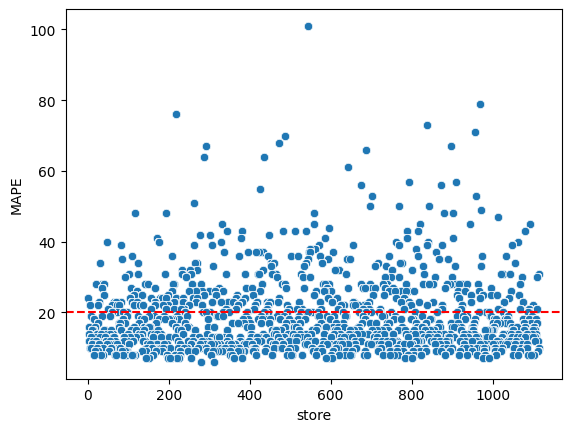

In [24]:
graph_errors(store_performance)

### Performance Total de Negócio

In [25]:
rossman_performance = store_performance[['prediction', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis = 0).reset_index().rename(columns = {'index': 'Scenario', 0: 'Receita'})
rossman_performance['Receita'] = rossman_performance['Receita'].map('R$ {:,.2f}'.format)
rossman_performance

,Scenario,Receita
0,prediction,"R$ 255,413,176.00"
1,worst_scenario,"R$ 203,437,298.00"
2,best_scenario,"R$ 307,389,054.00"


# Passo 09: Deploy do modelo ajustado

##### Consultar repositório <a href="https://github.com/bvmcosta/teste_app_render.git">Render web application</a>
##### Consultar repositório <a href="https://github.com/bvmcosta/teste_bot_telegram.git">Bot Telegram</a>